In [1]:
import tracemalloc
import pickle
from cov_3X2 import *
from lsst_utils import *
from scipy.stats import norm,mode,skew,kurtosis,percentileofscore
import seaborn as sns
import copy
colors=sns.color_palette()
markers=['o','s','^','>','v']

/usr/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
import lsst_utils
import cov_3X2
import tracer_utils
import window_utils
import cov_utils
import importlib
reload=importlib.reload
reload(lsst_utils)
reload(window_utils)
reload(cov_utils)
reload(tracer_utils)
reload(cov_3X2)
from lsst_utils import *
from cov_utils import *
from cov_3X2 import *

In [3]:
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [4]:
fig_home='./figures/'

In [5]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
worker_kwargs={'memory_spill_fraction':.75,'memory_target_fraction':.99,'memory_pause_fraction':1}
LC=LocalCluster(n_workers=1,processes=False,memory_limit='60gb',threads_per_worker=10,
                local_dir='/home/deep/repos/cosmic_shear/temp/NGL-worker/',
               **worker_kwargs,
                #scheduler_port=12234,
#                 dashboard_address=8801
                diagnostics_port=8801,
#                memory_monitor_interval='2000ms')
               )
client=Client(LC,diagnostics_port=8801,)

#LC.close()
#client.close()

In [6]:
client

Client Scheduler: inproc://136.152.250.206/25080/1 Dashboard: http://localhost:8801/status,Cluster Workers: 1 Cores: 10 Memory: 60.00 GB


In [7]:
nside=1024
l0w=np.arange(3*nside-1)

In [8]:
#setup parameters
# lmax_cl=1000
lmax_cl=1920#int(nside*2.9)
lmin_cl=0
l0=np.arange(lmin_cl,lmax_cl)

lmin_cl_Bins=lmin_cl+10
lmax_cl_Bins=lmax_cl-10
Nl_bins=37 #40
l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
# l_bins=np.int64(np.linspace(lmin_cl_Bins,lmax_cl_Bins,Nl_bins))
lb=(l_bins[1:]+l_bins[:-1])*.5

l=l0 #np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell

do_cov=True
bin_cl=True

SSV_cov=False
tidal_SSV_cov=False

do_xi=True

In [9]:
use_shot_noise=False

In [10]:
use_window=True
f_sky=0.3
n_source_bins=1
sigma_gamma=0.3944/sqrt(2.)  #*2**0.25

In [11]:
store_win=True
unit_window=True
smooth_window=False

In [12]:
w_smooth_lmax=1.e7 #some large number
if smooth_window:
    w_smooth_lmax=1000
window_cl_fact=np.cos(np.pi/2*(l0w/w_smooth_lmax)**10)
x=window_cl_fact<0
x+=l0w>w_smooth_lmax
window_cl_fact[x]=0
if unit_window:
    window_cl_fact=0

In [13]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
corr_kk=('kappa','kappa')
corr_gk=('galaxy','kappa')

In [14]:
do_cov=True
store_win=True

In [15]:
wigner_files={}
wigner_files[0]= 'temp/dask_wig3j_l6500_w2100_0_reorder.zarr'
wigner_files[2]= 'temp/dask_wig3j_l3500_w2100_2_reorder.zarr'



In [16]:
corrs=[corr_ll,corr_ggl,corr_gg]
window_lmax=2000

In [17]:
th_min=3./60
th_max=400./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30)
th2=np.linspace(1,th_max*1.02,n_th_bins*30)
# th2=np.logspace(np.log10(1),np.log10(th_max),60*6)
th=np.unique(np.sort(np.append(th,th2)))
thb=0.5*(th_bins[1:]+th_bins[:-1])

bin_xi=True

# HT_kwargs={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2),(0,2),(0,0)]}
l0_win=np.arange(lmax_cl)
WT_L_kwargs={'l': l0_win,'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
WT_L=None
if do_xi:
    %time WT_L=wigner_transform(**WT_L_kwargs)

./wigner_functions.py:39: RuntimeWarning: invalid value encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
./wigner_functions.py:39: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
./wigner_functions.py:39: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))


CPU times: user 349 ms, sys: 668 ms, total: 1.02 s
Wall time: 6.92 s


In [18]:
thb

array([0.05692912, 0.07270787, 0.09285993, 0.11859743, 0.15146846,
       0.19345019, 0.24706777, 0.31554625, 0.40300456, 0.51470324,
       0.65736085, 0.83955813, 1.07225409, 1.36944517, 1.74900715,
       2.23377035, 2.85289283, 3.64361427, 4.65349586, 5.94328106])

In [19]:
with open('./tests/xi_noiseless_chien_hao.pkl', 'rb') as f:
    dict_load = pickle.load(f)
    print(dict_load.keys())

dict_keys(['zs_bin', 'zl_bin', 'cl0', 'theta_bin_centers', 'data_vectors'])


In [20]:
zs_bin1=dict_load['zs_bin']
zl_bin1=dict_load['zl_bin']
xi_sim=dict_load['data_vectors']

In [21]:
zs_bin1[0].keys()

dict_keys(['z', 'dz', 'nz', 'ns', 'W', 'pz', 'pzdz', 'Norm', 'b1', 'AI', 'AI_z', 'mag_fact', 'lm', 'Gkernel', 'Gkernel_int', 'gkernel', 'gkernel_int', 'kernel_int', 'window', 'window_alm', 'window_alm_noise'])

/usr/lib/python3.7/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


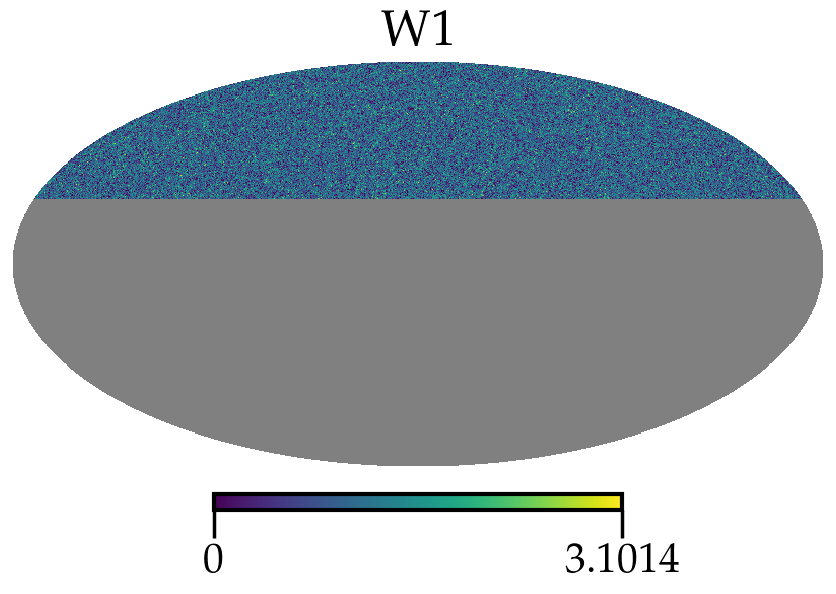

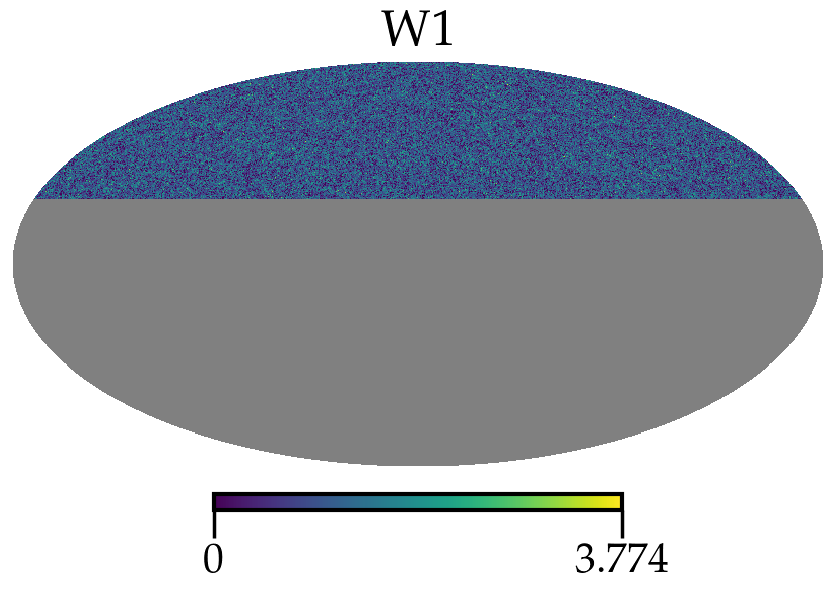

In [22]:
hp.mollview(zs_bin1[0]['window'],title='W1')
hp.mollview(zl_bin1[0]['window'],title='W1')
# hp.mollview(zs_bin1w[0]['window'],title='W2')
# hp.mollview(zl_bin1w[0]['window'],title='W2')
# hp.mollview(win_tt,title='window')

In [23]:
import window_utils
reload(window_utils)
from window_utils import *

import tracer_utils
reload(tracer_utils)
from tracer_utils import *


import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [24]:
client

Client Scheduler: inproc://136.152.250.206/25080/1 Dashboard: http://localhost:8801/status,Cluster Workers: 1 Cores: 10 Memory: 60.00 GB


In [25]:
zs_bin1['SN']['galaxy']

array([[[2.78166788e-07]]])

In [26]:
if not use_shot_noise:
    for t in zs_bin1['SN'].keys():
        zs_bin1['SN'][t]*=0
#         zs_bin1w['SN'][t]*=0
#         zl_bin1w['SN'][t]*=0
        zl_bin1['SN'][t]*=0

In [27]:
tracemalloc.clear_traces()
tracemalloc.start()


t1=time.time()
kappa_win=cov_3X2(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin1,
            use_window=use_window,store_win=store_win,window_lmax=window_lmax,corrs=corrs,
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
            HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi,
            wigner_files=wigner_files,
#                  Win=kappa_win.Win.Win
                 )

t2=time.time()
print('W done',t2-t1)

if do_xi:
    %time xiWG_L=kappa_win.xi_tomo()
    %time xiW_L=xiWG_L['stack'].compute()
else:
    %time clG_win=kappa_win.cl_tomo(corrs=corrs) 
    %time cl0_win=clG_win['stack'].compute()



./cov_utils.py:60: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017


shear [(0, 0)]
galaxy [(0, 0)]
Win gen: step size 84
wigner_files: {0: 'temp/dask_wig3j_l6500_w2100_0_reorder.zarr', 2: 'temp/dask_wig3j_l3500_w2100_2_reorder.zarr'}
wigner done dict_keys([0, 2])
setting windows <Client: scheduler='inproc://136.152.250.206/25080/1' processes=1 cores=10>


distributed.comm.inproc - WARNING - Closing dangling queue in <InProc local=inproc://136.152.250.206/25080/7 remote=inproc://136.152.250.206/25080/1>


got window cls, now to coupling matrices.
done coupling submatrix  0 19.910706281661987 4.914365768432617 13.063464164733887
done coupling submatrix  84 19.961697816848755 5.14725399017334 13.034689903259277
done coupling submatrix  168 20.090386867523193 5.363489866256714 13.060055017471313
done coupling submatrix  252 20.460915088653564 5.45400071144104 13.265357255935669
done coupling submatrix  336 20.56754207611084 5.637051105499268 13.314660549163818
done coupling submatrix  420 20.918380737304688 5.852103233337402 13.34438157081604
done coupling submatrix  504 21.179611444473267 6.061559200286865 13.384817838668823
done coupling submatrix  588 22.576672077178955 6.276977777481079 14.67309832572937
done coupling submatrix  672 21.90567898750305 6.5469419956207275 13.652646780014038
done coupling submatrix  756 21.8498854637146 6.718907594680786 13.565163135528564
done coupling submatrix  840 22.386122703552246 6.953578233718872 13.655370950698853
done coupling submatrix  924 22.6

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


cl dict done
CPU times: user 9.67 s, sys: 168 ms, total: 9.84 s
Wall time: 5.61 s
CPU times: user 58.3 s, sys: 341 ms, total: 58.6 s
Wall time: 7.56 s


In [28]:
tracemalloc.clear_traces()
tracemalloc.start()

t1=time.time()
if do_xi:
    kappa_win_approx=cov_3X2(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin1,
            use_window=False,store_win=store_win,window_lmax=window_lmax,corrs=corrs,
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
            HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi,
            wigner_files=wigner_files,
            Win=kappa_win.Win.Win,
            xi_win_approx=True
            )

    t2=time.time()
    print('W done',t2-t1)

    %time xiWG_L_approx=kappa_win_approx.xi_tomo()
    %time xiW_L_approx=xiWG_L['stack'].compute()

Win gen: step size 84
setting windows <Client: scheduler='inproc://136.152.250.206/25080/1' processes=1 cores=10>
W done 186.46437120437622
cl dict done
CPU times: user 9.37 s, sys: 114 ms, total: 9.48 s
Wall time: 5.25 s
CPU times: user 58 s, sys: 239 ms, total: 58.2 s
Wall time: 7.5 s


In [139]:
kappa_win.Win.Win['cl'][corr_ll][(0,0)]['xi'],kappa_win.Win.Win['cl'][corr_ll][(0,0)]['xi_b']

(array([0.32789942, 0.32781656, 0.32773306, ..., 0.28274214, 0.28272188,
        0.28270076]),
 array([0.3250237 , 0.31917844, 0.31201088, 0.30498551, 0.30103087,
        0.30208081, 0.30394182, 0.30122674, 0.30077263, 0.29974651,
        0.29918457, 0.29831201, 0.29752861, 0.29659196, 0.29555963,
        0.29427906, 0.29265724, 0.29064845, 0.28808654, 0.28479209]))

In [29]:
snapshot1 = tracemalloc.take_snapshot()

In [30]:
top_stats = snapshot1.statistics('lineno')
# top_stats

In [31]:
stat = top_stats[3]
print("%s memory blocks: %.1f MiB" % (stat.count, stat.size / 1024**2))
for line in stat.traceback.format():
    print(line)

13 memory blocks: 3.8 MiB
  File "/home/deep/repos/cosmic_shear/power_spectra.py", line 277
    pkC=np.array([[cosmoC.pk(ki,zj) for ki in k ]for zj in z])


In [32]:
l=kappa_win.window_l
Om_W=np.pi*4*f_sky
theta_win=np.sqrt(Om_W/np.pi)
l_th=l*theta_win
Win0=2*jn(1,l_th)/l_th
Win0=np.nan_to_num(Win0)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [33]:
kappa_win.z_bins.keys()

dict_keys(['shear', 'galaxy'])

In [34]:
bi=(0,0)

In [35]:
R=kappa_win.Win.Win['cl'][corr_gg][bi]['M']/kappa_win.Win.Win['cl'][corr_ll][bi]['M']
R=np.nan_to_num(R)
x=R>0
R[x].max()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


1.7976931348623157e+308

In [36]:
corrs

[('shear', 'shear'), ('galaxy', 'shear'), ('galaxy', 'galaxy')]

In [37]:
import tracer_utils
reload(tracer_utils)
from tracer_utils import *
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [38]:
kappa0=cov_3X2(zs_bins=copy.deepcopy(zs_bin1),do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin1,
            use_window=False,store_win=store_win,corrs=corrs,
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
            HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi)

%time clG0=kappa0.cl_tomo(corrs=corrs) 
if do_xi:
    %time xiG_L0=kappa0.xi_tomo()
    %time xi_L0=xiG_L0['stack'].compute()
else:
    
    %time cl0=clG0['stack'].compute()

shear [(0, 0)]
galaxy [(0, 0)]
Win gen: step size 1921
cl dict done
CPU times: user 9.23 s, sys: 137 ms, total: 9.36 s
Wall time: 5.09 s
cl dict done
CPU times: user 9.22 s, sys: 102 ms, total: 9.32 s
Wall time: 5.09 s
CPU times: user 55.9 s, sys: 210 ms, total: 56.1 s
Wall time: 6.77 s


In [39]:
kappa0_kk=cov_3X2(zk_bins=copy.deepcopy(zs_bin1),do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin1,
            use_window=False,store_win=store_win,corrs=[corr_kk,corr_gk,corr_gg],
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
            HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi)

%time clG0kk=kappa0_kk.cl_tomo(corrs=[corr_kk,corr_gk,corr_gg]) 
if do_xi:
    %time xiG_kkL0=kappa0_kk.xi_tomo(corrs=[corr_kk,corr_gk,corr_gg])
    %time xi_kkL0=xiG_kkL0['stack'].compute()
else:
    %time cl0_kk=clG0kk['stack'].compute()

kappa [(0, 0)]
Win gen: step size 1921
cl dict done
CPU times: user 9.35 s, sys: 162 ms, total: 9.51 s
Wall time: 5.26 s
cl dict done
CPU times: user 9.19 s, sys: 156 ms, total: 9.34 s
Wall time: 5.11 s
CPU times: user 33.7 s, sys: 158 ms, total: 33.8 s
Wall time: 4.48 s


In [40]:
bi=(0,0)
corr=corr_ll
cl_s=clG0['cl'][corr][bi].compute()
corr=corr_kk
cl_k=clG0kk['cl'][corr][bi].compute()

# plot(cl_s/cl_k)
# plot(cl_k)
# loglog()

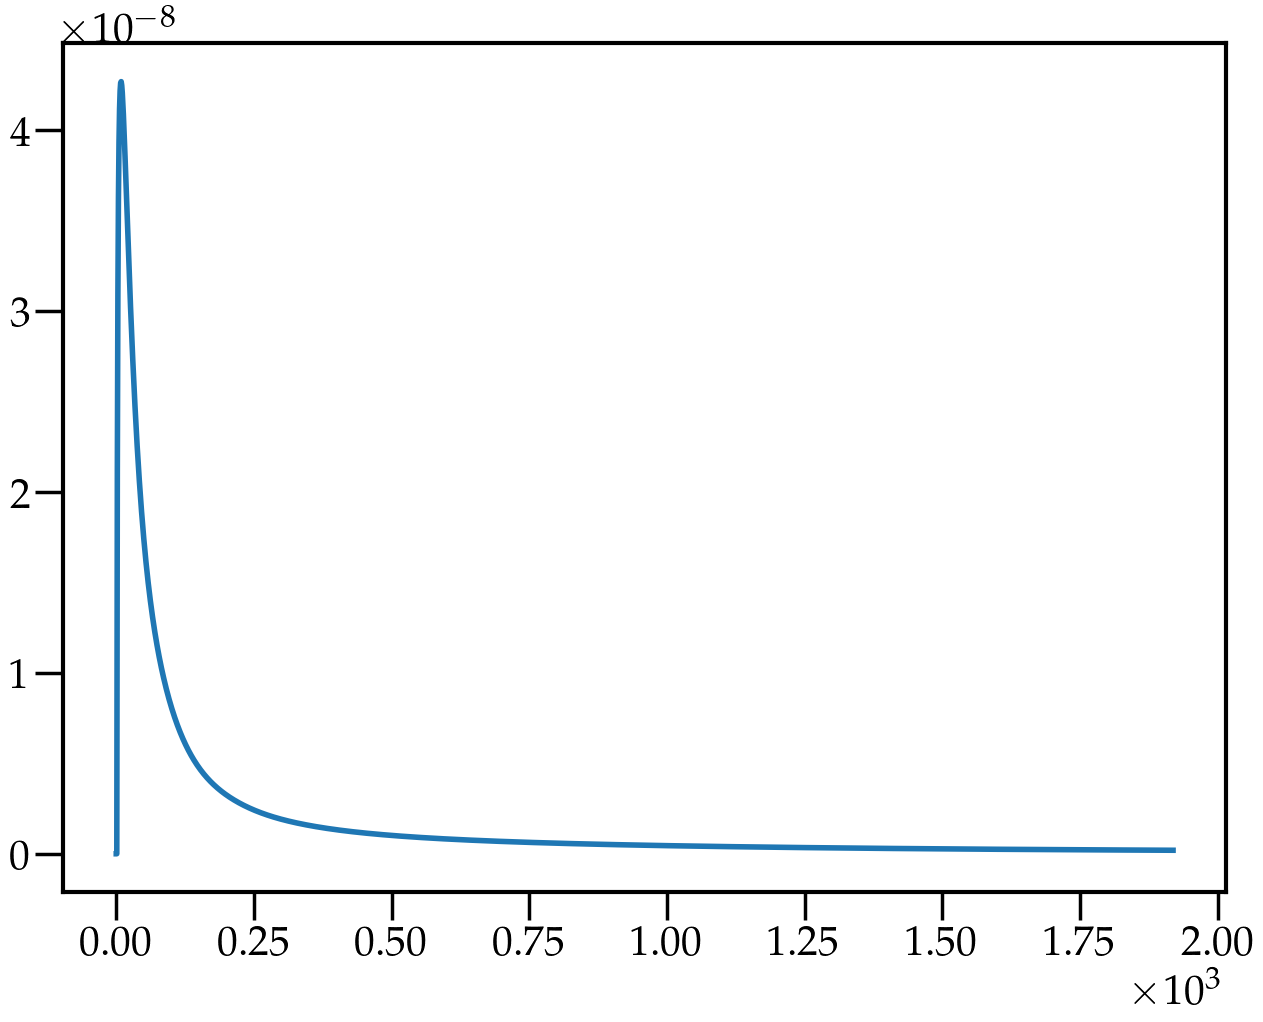

In [41]:
plot(l0,cl_s)

In [42]:
tht,xi_sk=kappa0.HT.projected_correlation(l_cl=l0,cl=cl_k,m1_m2=(2,2))
xi_sk=kappa0.binning.bin_1d(xi=xi_sk,bin_utils=kappa0.xi_bin_utils[(2,2)])

tht,xi_ks=kappa0_kk.HT.projected_correlation(l_cl=l0,cl=cl_s,m1_m2=(0,0))
xi_ks=kappa0.binning.bin_1d(xi=xi_ks,bin_utils=kappa0_kk.xi_bin_utils[(0,0)])

In [43]:
cl_sim=np.genfromtxt('./temp/cl_sim.dat',names=True)
tht,xiS_s=kappa0.HT.projected_correlation(l_cl=cl_sim['l'],cl=cl_sim['cls'],m1_m2=(2,2))
xiS_s=kappa0.binning.bin_1d(xi=xiS_s,bin_utils=kappa0.xi_bin_utils[(2,2)])

tht,xiS_m=kappa0.HT.projected_correlation(l_cl=cl_sim['l'],cl=cl_sim['cls'],m1_m2=(2,-2))
xiS_m=kappa0.binning.bin_1d(xi=xiS_m,bin_utils=kappa0.xi_bin_utils[(2,-2)])

tht,xiS_k=kappa0.HT.projected_correlation(l_cl=cl_sim['l'],cl=cl_sim['clk'],m1_m2=(0,0))
xiS_k=kappa0.binning.bin_1d(xi=xiS_k,bin_utils=kappa0.xi_bin_utils[(0,0)])
# xi_sk=kappa0.binning.bin_1d(xi=xi_sk,bin_utils=kappa0.xi_bin_utils[(2,2)])

# tht,xi_ks=kappa0_kk.HT.projected_correlation(l_cl=l0,cl=cl_s,m1_m2=(0,0))
# xi_ks=kappa0.binning.bin_1d(xi=xi_ks,bin_utils=kappa0_kk.xi_bin_utils[(0,0)])

np.savetxt('./temp/corr_sim_predict_xipm_kappa.dat',np.column_stack((thb*60,xiS_s,xiS_m,xiS_k)),header='th xis xim xik')

In [45]:
corr=corr_ll
m1_m2=(2,2)
bi=(0,0)
xi_s=xiG_L0['xi'][corr][m1_m2][bi].compute()
m1_m2=(2,-2)
xi_m=xiG_L0['xi'][corr][m1_m2][bi].compute()
corr=corr_kk
m1_m2=(0,0)
xi_k=xiG_kkL0['xi'][corr][m1_m2][bi].compute()

In [46]:
np.savetxt('./temp/corr_theory_xip_kappa.dat',np.column_stack((thb*60,xi_s,xi_sk,xi_ks,xi_k,xi_m)),header='th xis xisk xiks xik xim')
np.savetxt('./temp/cl_theory.dat',np.column_stack((l0,cl_s,cl_k)),header='l cls clk')

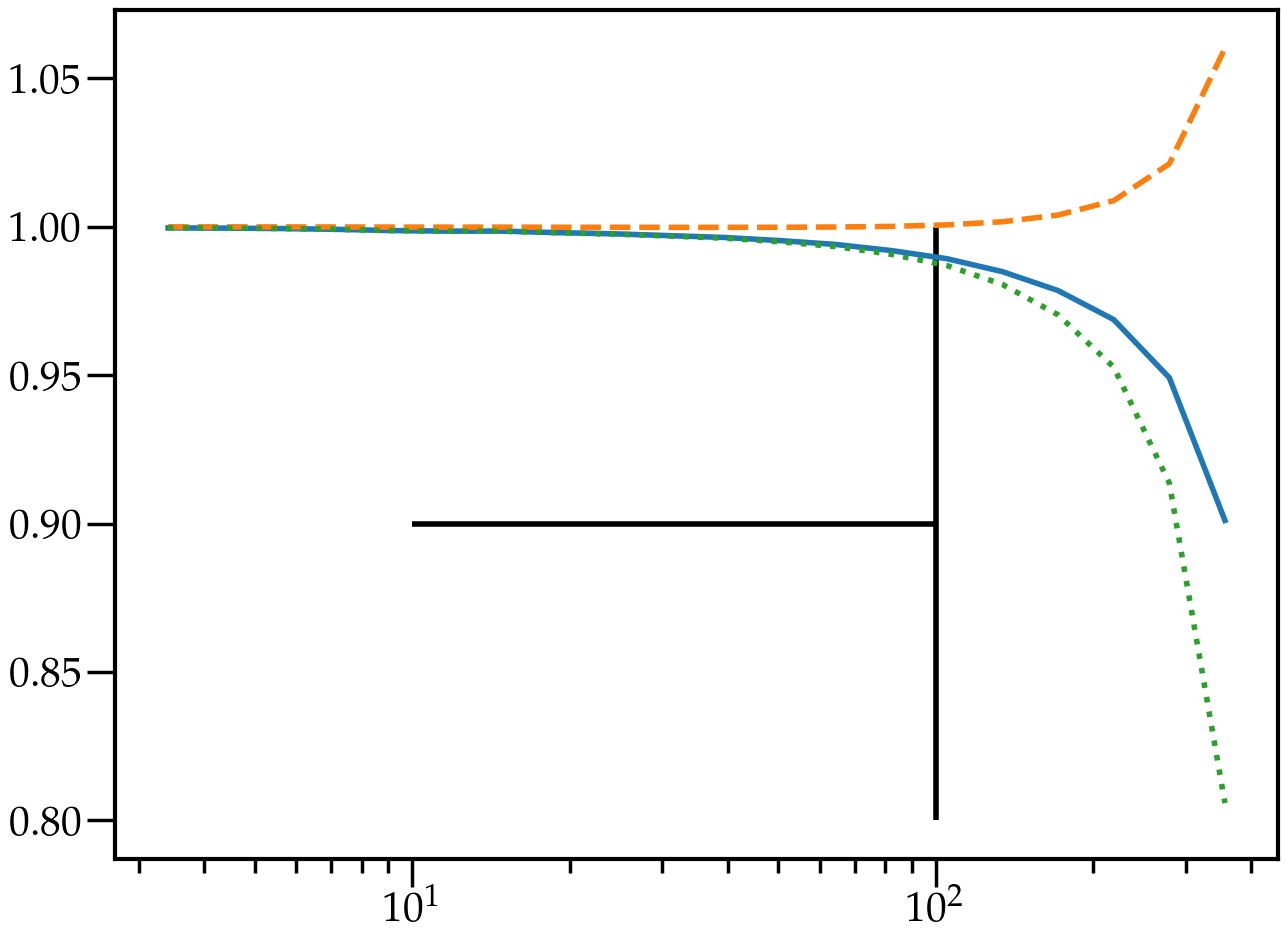

In [47]:
plot(thb*60,xi_s/xi_k)
plot(thb*60,xi_sk/xi_k,'--')
plot(thb*60,xi_ks/xi_k,':')
# plot(thb/d2r,xi_k)
xscale('log')
# ylim(0.8,1.01)
vlines(100,0.8,1)
hlines(.9,10,100)

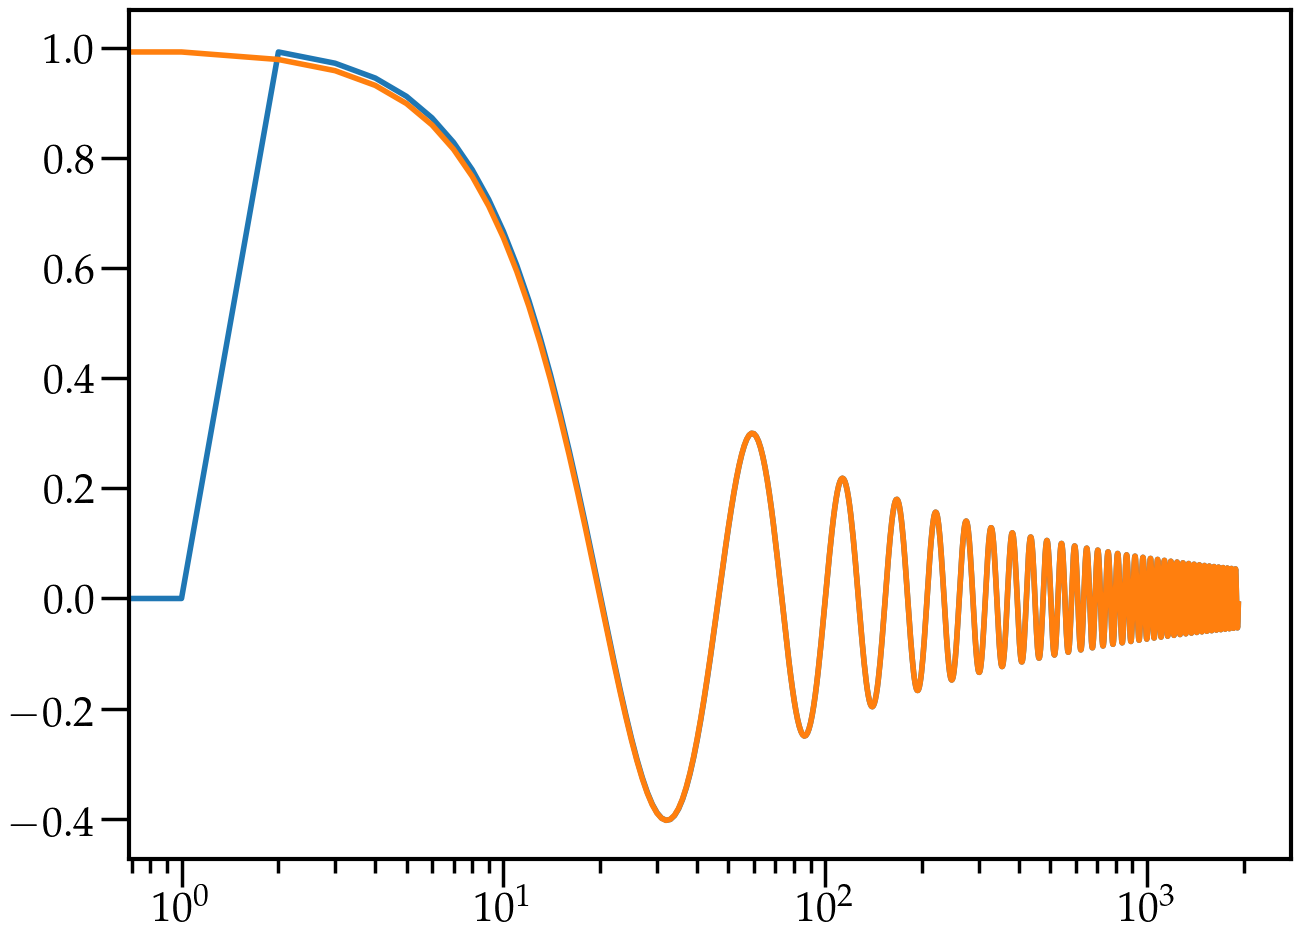

In [48]:
thi=1190
plot(l0,WT_L.wig_d[(2,2)][thi,:])
plot(l0,WT_L.wig_d[(0,0)][thi,:])
xscale('log')
# yscale('log')

In [49]:
m1_m2s=kappa0.m1_m2s

In [50]:
m1_m2s

{('shear', 'shear'): [(2, 2), (2, -2)],
 ('shear', 'galaxy'): [(2, 0)],
 ('galaxy', 'shear'): [(0, 2)],
 ('galaxy', 'galaxy'): [(0, 0)],
 'window': [(0, 0)]}

In [86]:
bi=(0,0)
xi0p={'xi':{},'cov':{},'cl':{}}
xi0m={'xi':{},'cov':{},'cl':{}}
xi0m_win={'xi':{},'cov':{}}
xi0p_win={'xi':{},'cov':{}}
xi0m_win_approx={'xi':{},'cov':{}}
xi0p_win_approx={'xi':{},'cov':{}}


for corr in corrs:
    if corr==corr_ll:
        m1_m2=m1_m2s[corr][1]
        xi0m['xi'][corr]=xiG_L0['xi'][corr][m1_m2][bi].compute()
        xi0m['cov'][corr]=xiG_L0['cov'][corr+corr][m1_m2+m1_m2][bi+bi].compute()

        xi0m_win['xi'][corr]=xiWG_L['xi'][corr][m1_m2][bi].compute()
        xi0m_win['cov'][corr]=xiWG_L['cov'][corr+corr][m1_m2+m1_m2][bi+bi].compute()['final']
        
        xi0m_win_approx['xi'][corr]=xiWG_L_approx['xi'][corr][m1_m2][bi].compute()
        xi0m_win_approx['cov'][corr]=xiWG_L_approx['cov'][corr+corr][m1_m2+m1_m2][bi+bi].compute()['final']
        
    m1_m2=m1_m2s[corr][0]
    xi0p['xi'][corr]=xiG_L0['xi'][corr][m1_m2][bi].compute()
    xi0p['cov'][corr]=xiG_L0['cov'][corr+corr][m1_m2+m1_m2][bi+bi].compute()
    
    xi0p_win['xi'][corr]=xiWG_L['xi'][corr][m1_m2][bi].compute()
    xi0p_win['cov'][corr]=xiWG_L['cov'][corr+corr][m1_m2+m1_m2][bi+bi].compute()['final']
    
    xi0p_win_approx['xi'][corr]=xiWG_L_approx['xi'][corr][m1_m2][bi].compute()
    xi0p_win_approx['cov'][corr]=xiWG_L_approx['cov'][corr+corr][m1_m2+m1_m2][bi+bi].compute()['final']

In [87]:
def corr_matrix(cov_mat=[]): #correlation matrix
    diag=np.diag(cov_mat)
    return cov_mat/np.sqrt(np.outer(diag,diag))

In [88]:
def bin_coupling_M(kappa_class,coupling_M): #following https://arxiv.org/pdf/astro-ph/0105302.pdf 
#construct coupling matrix for the binned c_ell. This assumes that the C_ell within a bin follows powerlaw. 
#Without this assumption we cannot undo the effects of binning
    l=kappa_class.l
    bin_M=kappa_win.cl_bin_utils['binning_mat']
    l2=l*(l+1)
    x=l==0
    l2[x]=1
    Q=bin_M.T*np.pi*2/(l2)
    P=bin_M.T*(l2)/(np.pi*2)
    P=P.T/(kappa_class.l_bins[1:]-kappa_class.l_bins[:-1])
    return P.T@coupling_M@Q.T

In [89]:
def bin_coupling_M2(kappa_class,coupling_M): #following https://arxiv.org/pdf/astro-ph/0105302.pdf 
#construct coupling matrix for the binned c_ell. This assumes that the C_ell within a bin follows powerlaw. 
#Without this assumption we cannot undo the effects of binning
    l=kappa_class.l
    bin_M=kappa_win.cl_bin_utils['binning_mat']
    
    l2=l*(l+1)
    x=l==0
    l2[x]=1
    
    Q=bin_M.T*np.pi*2/(l2)**2
    P=bin_M.T*(l2)**2/(np.pi*2)
    P=P.T/(kappa_class.l_bins[1:]-kappa_class.l_bins[:-1])
    return P.T@coupling_M@Q.T

In [90]:
seed=12334
def get_clsim2(clg0,window,mask,kappa_class,coupling_M,coupling_M_inv,ndim,i):
    print(i)
    local_state = np.random.RandomState(seed+i)
    cl_map=hp.synfast(clg0,nside=nside,RNG=local_state,new=True,pol=True)

    if ndim>1:
        cl_map[0]*=window['galaxy']
        cl_map[0][mask['galaxy']]=hp.UNSEEN
        cl_map[1]*=window['shear'] #shear_1
        cl_map[2]*=window['shear']#shear_2
        cl_map[1][mask['shear']]=hp.UNSEEN
        cl_map[2][mask['shear']]=hp.UNSEEN
        clpi=hp.anafast(cl_map, lmax=max(l),pol=True) #TT, EE, BB, TE, EB, TB for polarized input map
        clpi=clpi[:,l]
        clpi=clpi[[0,1,3],:]
#             for i in np.arange(6):

    else:
        cl_map*=window
        cl_map[mask]=hp.UNSEEN
        clpi=hp.anafast(cl_map, lmax=max(l),pol=True)[l]
        
    del cl_map

    if ndim>1:
        clpi[0]-=(np.ones_like(clpi[0])*kappa_class.SN[corr_gg][:,0,0])@coupling_M[corr_gg]*use_shot_noise
        clpi[1]-=(np.ones_like(clpi[1])*kappa_class.SN[corr_ll][:,0,0])@coupling_M[corr_ll]*use_shot_noise
        clpi[1]-=(np.ones_like(clpi[1])*kappa_class.SN[corr_ll][:,0,0])@coupling_M['shear_B']*use_shot_noise #remove B-mode leakage

        clgi=[clpi[0]@coupling_M_inv[corr_gg],
              clpi[1]@coupling_M_inv[corr_ll],
              clpi[2]@coupling_M_inv[corr_ggl]]
    else:
        clpi-=(np.ones_like(clpi)*shot_noise)@coupling_M
        clgi=clpi@coupling_M_inv
    clgi=np.array(clgi)
    return [clpi.T,clgi.T]

In [91]:
def calc_sim_stats(sim=[],sim_truth=[],PC=False):
    sim_stats={}
    sim_stats['std']=np.std(sim,axis=0)    
    sim_stats['mean']=np.mean(sim,axis=0)
    sim_stats['median']=np.median(sim,axis=0)
    sim_stats['percentile']=np.percentile(sim,[16,84],axis=0)
#     sim_stats['skew']=skew(sim,axis=0)
#     sim_stats['kurt']=kurtosis(sim,axis=0)
    sim_stats['cov']=np.cov(sim,rowvar=0)
    
#     if not PC:
#         try:
#             sim_stats['cov_ev'],sim_stats['cov_evec']=np.linalg.eig(sim_stats['cov'])
#             sim_stats['PC']={}
#             sim_stats['PC']['data']=(sim_stats['cov_evec'].T@sim.T).T
#             sim_stats['PC']['stats']=calc_sim_stats(sim=sim_stats['PC']['data'],PC=True)
#         except Exception as err:
#             print(err)
#             sim_stats['PC']=err
#     else:
#         sim_truth=sim_stats['mean']
    
    sim_stats['percetile_score']=np.zeros_like(sim_stats['std'])
    if len(sim_stats['std'].shape)==1:
        for i in np.arange(len(sim_stats['std'])):
            sim_stats['percetile_score'][i]=percentileofscore(sim[:,i],sim_truth[i])
    elif len(sim_stats['std'].shape)==2:
        for i in np.arange(len(sim_stats['std'])):
            for i_dim in np.arange(2):
                for j_dim in np.arange(2):
                    sim_stats['percetile_score'][i][i_dim,j_dim]=percentileofscore(sim[:,i,i_dim,j_dim],
                                                                                   sim_truth[i,i_dim,j_dim])
    else:
        sim_stats['percetile_score']='not implemented for ndim>2'
    return sim_stats
    
def sim_cl_xi(Rsize=150,do_norm=False,cl0=None,kappa_class=None,fsky=f_sky,zbins=None,use_shot_noise=True,
             convolve_win=False,nside=nside,use_cosmo_power=True):
    l=kappa_class.l
    shear_lcut=l>=2
    
    l_bins=kappa_class.l_bins
    dl=l_bins[1:]-l_bins[:-1]
    nu=(2.*l+1.)*fsky
    
    coupling_M={}
    coupling_M_N={}
    coupling_M_binned={'Master':{},'nMaster':{},'iMaster':{}}    
    coupling_M_inv={}
    coupling_M_binned_inv={'Master':{},'nMaster':{},'iMaster':{}}
    
    coupling_M4={}
    coupling_M4_binned={}
    coupling_M4_binned2={}

    mask={}
    window={}
    if convolve_win:
        nu=2.*l+1.
        for tracer in kappa_class.z_bins.keys():
            window[tracer]=kappa_class.z_bins[tracer][0]['window']
            mask[tracer]=window[tracer]==hp.UNSEEN
        for corr in corrs:
            coupling_M[corr]=kappa_class.Win.Win['cl'][corr][(0,0)]['M']
            coupling_M_N[corr]=kappa_class.Win.Win['cl'][corr][(0,0)]['M_noise']
            if corr==corr_ll:
                coupling_M['shear_B']=kappa_class.Win.Win['cl'][corr][(0,0)]['M_B']
                coupling_M_N['shear_B']=kappa_class.Win.Win['cl'][corr][(0,0)]['M_B_noise']
            coupling_M_binned['Master'][corr]=bin_coupling_M(kappa_class,coupling_M[corr])
            coupling_M_binned['nMaster'][corr]=kappa_class.binning.bin_2d(cov=coupling_M[corr],bin_utils=kappa_class.cl_bin_utils) 
            coupling_M_binned['nMaster'][corr]*=dl
            
            coupling_M_binned['iMaster'][corr]=M_binnings[corr].bin_2d_coupling(cov=coupling_M[corr].T,bin_utils=M_binning_utils[corr])
            coupling_M_binned['iMaster'][corr]=coupling_M_binned['iMaster'][corr].T  #to keep the same order in dot product later. Remeber that the coupling matrix is not symmetric.
            
            if corr==corr_ll:
                coupling_M_binned['iMaster']['shear_B']=M_binnings[corr].bin_2d_coupling(cov=coupling_M['shear_B'].T,bin_utils=M_binning_utils[corr])
                coupling_M_binned['iMaster']['shear_B']=coupling_M_binned['iMaster']['shear_B'].T  #to keep the same order in dot product later. Remeber that the coupling matrix is not symmetric.
                
                
#             coupling_M4=kappa_win.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][s] #*2
#             coupling_M4_binned[corr]=bin_coupling_M(kappa_class,coupling_M4[corr])
#             coupling_M4_binned2[corr]=kappa_class.binning.bin_2d(cov=coupling_M4[corr],bin_utils=kappa_class.cl_bin_utils) 
#             coupling_M4_binned2[corr]*=dl
#         kappa_class.binning.bin_2d(cov=coupling_M,bin_utils=kappa_win.cl_bin_utils)
#             print(corr,coupling_M[corr])
            
            cut=l>=0
            if 'shear' in corr:
                cut=shear_lcut 
            coupling_M_inv[corr]=np.zeros_like(coupling_M[corr])
#             coupling_M_inv[corr][:,cut][cut,:]+=np.linalg.inv(coupling_M[corr][cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.
            MT=np.linalg.inv(coupling_M[corr][cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.
            coupling_M_inv[corr]=np.pad(MT,((~cut).sum(),0),mode='constant',constant_values=0)
            
            for k in coupling_M_binned.keys():
                coupling_M_binned_inv[k][corr]=np.linalg.inv(coupling_M_binned[k][corr])
            if corr==corr_ll:
                coupling_M_inv['shear_B']=np.zeros_like(coupling_M['shear_B'])
                coupling_M_inv['shear_B'][:,cut][cut,:]=np.linalg.inv(coupling_M['shear_B'][cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.
                coupling_M_binned_inv['iMaster']['shear_B']=np.linalg.inv(coupling_M_binned['iMaster']['shear_B'])
#             print(coupling_M_inv.keys())
    outp={}
    win=0
    clp_shear_B=None
    if cl0 is None:
        cl0={}
        clp0={}
        clG0=kappa_class.cl_tomo() 
        for corr in kappa_class.corrs:
            cl0[corr]=clG0['cl'][corr][(0,0)].compute()
            clp0[corr]=clG0['cl_b'][corr][(0,0)].compute()
    clg0={}
    clN0={}
    for corr in kappa_class.corrs: #ordering: TT, EE, BB, TE if 4 cl as input.. use newbool=True
        shot_noise=kappa_class.SN[corr_gg][:,0,0]*0
        if corr[0]==corr[1]:
            shot_noise=kappa_class.SN[corr][:,0,0]
        shot_noise=shot_noise*use_shot_noise
        clN0[corr]=shot_noise
        clg0[corr]=cl0[corr]*use_cosmo_power#+shot_noise
        if corr==corr_ll:
            clg0['shear_B']=cl0[corr]*0
            clN0['shear_B']=shot_noise
            #clp_shear_B=shot_noise@coupling_M[corr_ll]+(cl0[corr_ll]+shot_noise)@coupling_M['shear_B']
            clp_shear_B=cl0[corr_ll]@coupling_M['shear_B']
    ndim=len(kappa_class.corrs)
    print('ndim:',ndim)
    outp['clg0_0']=clg0.copy()
    outp['clN0_0']=clN0.copy()
    outp['ndim']=ndim
    if ndim>1:
        clg0=(clg0[corr_gg],clg0[corr_ll],clg0['shear_B'],clg0[corr_ggl])#ordering: TT, EE, BB, TE if 4 cl as input.. use newbool=True
        clN0=(clN0[corr_gg],clN0[corr_ll],clN0['shear_B'],clN0[corr_ggl])#ordering: TT, EE, BB, TE if 4 cl as input.. use newbool=True
    else:
        clg0=clg0[corr_gg]
        clN0=clN0[corr_gg]
    
    SN=kappa_class.SN
    sim_cl_shape=(Rsize,len(kappa_class.l),ndim)
    
    clp=np.zeros(sim_cl_shape,dtype='float32')
    clg=np.zeros(sim_cl_shape,dtype='float32')
    clpB=np.zeros(sim_cl_shape,dtype='float32')
    clgB=np.zeros(sim_cl_shape,dtype='float32')
    lmax=max(l)
    lmin=min(l)
    
    
    clg_b=None
    clp_b=None
    clpB_b=None
    nu_b=None
    if l_bins is not None:
        clg0_b={corr: kappa_class.binning.bin_1d(xi=cl0[corr],bin_utils=kappa_class.cl_bin_utils) for corr in kappa_class.corrs} 
        ll=kappa_class.cl_bin_utils['bin_center']
        sim_clb_shape=(Rsize,len(ll),ndim)
        nu_b=(2.*ll+1.)*fsky*(l_bins[1:]-l_bins[:-1])
        clg_b={'unbinned':np.zeros(sim_clb_shape,dtype='float32'),
                'Master':np.zeros(sim_clb_shape,dtype='float32'),
               'nMaster':np.zeros(sim_clb_shape,dtype='float32'),
               'iMaster':np.zeros(sim_clb_shape,dtype='float32')}    
        clgB_b={'iMaster':np.zeros(sim_clb_shape,dtype='float32')}
#                'nMaster':np.zeros(sim_clb_shape,dtype='float32'),
#                'Master':np.zeros(sim_clb_shape,dtype='float32')}    
        clp_b=np.zeros(sim_clb_shape,dtype='float32')
        
        clpB_b=np.zeros(sim_clb_shape,dtype='float32')
        
        binning_func=kappa_class.binning.bin_1d
        binning_utils=kappa_class.cl_bin_utils
        
        clp_shear_B_b=binning_func(xi=clp_shear_B,bin_utils=binning_utils)
        
    corr_t=[corr_gg,corr_ll,corr_ggl] #order in which sim corrs are output.
    seed=12334
    def get_clsim(i):
        print('doing map: ',i)
        local_state = np.random.RandomState(seed+i)
        cl_map=hp.synfast(clg0,nside=nside,RNG=local_state,new=True,pol=True)
        N_map=0
        if use_shot_noise:
            N_map=hp.synfast(clN0,nside=nside,RNG=local_state,new=True,pol=True)
        
        tracers=['galaxy','shear','shear']
        if ndim>1:
            for i in np.arange(3):
                tracer=tracers[i]
                cl_map[i]*=window[tracer]
                if use_shot_noise:
                    N_map[i]*=np.sqrt(window[tracer])
                    cl_map[i]+=N_map[i]
                    N_map[i][mask[tracer]]=hp.UNSEEN
                cl_map[i][mask[tracer]]=hp.UNSEEN
                
            
            clpi=hp.anafast(cl_map, lmax=max(l),pol=True) #TT, EE, BB, TE, EB, TB for polarized input map
            clpi=clpi[:,l]
            clpi_B=clpi[[2,4,5],:]
            clpi=clpi[[0,1,3],:]
            
#             for i in np.arange(6):
            
            
        else:
            cl_map*=window
            cl_map[mask]=hp.UNSEEN
            clpi=hp.anafast(cl_map, lmax=max(l),pol=True)[l]

        if ndim>1:
            if use_shot_noise:
                clpi[0]-=(np.ones_like(clpi[0])*SN[corr_gg][:,0,0])@coupling_M_N[corr_gg]*use_shot_noise
                clpi[1]-=(np.ones_like(clpi[1])*SN[corr_ll][:,0,0])@coupling_M_N[corr_ll]*use_shot_noise
                clpi[1]-= (np.ones_like(clpi[1])*SN[corr_ll][:,0,0])@coupling_M_N['shear_B']*use_shot_noise #remove B-mode 
                clpi_B[0]-=(np.ones_like(clpi[1])*SN[corr_ll][:,0,0])@coupling_M_N['shear_B']*use_shot_noise #remove B-mode 
                clpi_B[0]-=(np.ones_like(clpi[1])*SN[corr_ll][:,0,0])@coupling_M_N[corr_ll]*use_shot_noise
            
            clgi=[clpi[0]@coupling_M_inv[corr_gg],
                  clpi[1]@coupling_M_inv[corr_ll],
                  clpi[2]@coupling_M_inv[corr_ggl]]
            clgBi=[clpi_B[0]@coupling_M_inv['shear_B'],
                  clpi[1]*0,
                  clpi[2]*0]
            
        else:
            clpi-=(np.ones_like(clpi)*shot_noise)@coupling_M
            clgi=clpi@coupling_M_inv
        
        clgi=np.array(clgi)

        if l_bins is not None:
            corr_t=[corr_gg,corr_ll,corr_ggl]
            sim_clb_shape=(len(ll),ndim)
            
            clg_b=np.zeros(sim_clb_shape,dtype='float32')
            
            clg_b={'unbinned':np.zeros(sim_clb_shape,dtype='float32'),
                    'Master':np.zeros(sim_clb_shape,dtype='float32'),
                   'nMaster':np.zeros(sim_clb_shape,dtype='float32'),
                   'iMaster':np.zeros(sim_clb_shape,dtype='float32')}    
            clgB_b={'iMaster':np.zeros(sim_clb_shape,dtype='float32')}                
            
            clp_b=np.zeros(sim_clb_shape,dtype='float32')
            clpB_b=np.zeros(sim_clb_shape,dtype='float32')
            for ii in np.arange(ndim):
                clg_b['unbinned'][:,ii]=binning_func(xi=clgi[ii],bin_utils=binning_utils)
                clp_b[:,ii]=binning_func(xi=clpi[ii],bin_utils=binning_utils)
                clpB_b[:,ii]=binning_func(xi=clpi_B[ii],bin_utils=binning_utils)
                for k in coupling_M_binned_inv.keys():
                    clg_b[k][:,ii]=clp_b[:,ii]@coupling_M_binned_inv[k][corr_t[ii]] #be careful with ordering as coupling matrix is not symmetric
                if corr_t[ii]==corr_ll:
                    clgB_b['iMaster'][:,ii]=clpB_b[:,ii]@coupling_M_binned_inv['iMaster']['shear_B']
                
            return clpi.T,clgi.T,clp_b,clpi_B.T,clg_b,clpB_b,clgB_b
        else:
            return clpi.T,clgi.T
    
    def comb_maps(futures):
        for i in np.arange(Rsize):
            x=futures[i]#.compute()
            clp[i,:,:]+=x[0]
            clg[i,:,:]+=x[1]
        return clp,clg 
    
    print('generating maps')
    if convolve_win:
        futures={}
#         for i in np.arange(Rsize):
#             futures[i]=dask.delayed(get_clsim)(i)  
#         print(futures)
#         clpg=dask.delayed(comb_maps)(futures)
#         clpg.compute()
        i=0
        j=0
        step=min(5,Rsize)
        funct=partial(get_clsim2,clg0,window,mask,SN,coupling_M,coupling_M_inv,ndim)
        while j<Rsize:
            futures={}
            for ii in np.arange(step):
                futures[ii]=delayed(get_clsim)(i+ii)  
            futures=client.compute(futures)
            for ii in np.arange(step):
                if l_bins is None:
                    clp[i,:],clg[i,:]=futures.result()[ii]
                else:
                    clp[i,:],clg[i,:],clp_b[i,:],clpB[i,:],clg_b_i,clpB_b[i,:],clgB_b_i=futures.result()[ii]
                    for k in clg_b_i.keys():
                        clg_b[k][i,:]=clg_b_i[k]
                    clgB_b['iMaster'][i,:]=clgB_b_i['iMaster']
                        
                i+=1
            print('done map ',i)
            del futures
            client.restart()
            j+=step
        
    print('done generating maps')
    
    outp['clg_b_stats']={}
    outp['clgB_b_stats']={}
    for k in clg_b.keys():
        outp['clg_b_stats'][k]=client.compute({corr_t[ii]: delayed(calc_sim_stats)(sim=clg_b[k][:,:,ii],sim_truth=clg0_b[corr_t[ii]]) for ii in np.arange(ndim)})
    k='iMaster'
    outp['clgB_b_stats'][k]=client.compute({corr_t[ii]: delayed(calc_sim_stats)(sim=clgB_b[k][:,:,ii],sim_truth=clg0_b[corr_t[ii]]) for ii in np.arange(ndim)})
    outp['clp_b_stats']=client.compute({corr_t[ii]: delayed(calc_sim_stats)(sim=clp_b[:,:,ii],sim_truth=clp_b[:,:,ii].mean(axis=0)) for ii in np.arange(ndim)})
    outp['clpB_b_stats']=client.compute({corr_t[ii]: delayed(calc_sim_stats)(sim=clpB_b[:,:,ii],sim_truth=clpB_b[:,:,ii].mean(axis=0)) for ii in np.arange(ndim)})
    
    for k in clg_b.keys():
        outp['clg_b_stats'][k]=outp['clg_b_stats'][k].result()
    k='iMaster'
    outp['clgB_b_stats'][k]=outp['clgB_b_stats'][k].result()
    outp['clp_b_stats']=outp['clp_b_stats'].result()
    outp['clpB_b_stats']=outp['clpB_b_stats'].result()
        
#         outp['clp_b_stats']=calc_sim_stats(sim=clp_b,sim_truth=clp_b.mean(axis=0))
#     xiN=np.zeros((Rsize,len(xi)))
#     xig=np.zeros((Rsize,len(xi)))
#     xigB=np.zeros((Rsize,len(r_bins)-1))
#     xiNB=np.zeros((Rsize,len(r_bins)-1))
#     for i in np.arange(Rsize):
#         r,xig[i,:]=HT.projected_correlation(k_pk=l,pk=clg[i,:],j_nu=0,taper=True,**taper_kw)
#         rb,xigB[i,:]=HT.bin_mat(r=r,mat=xig[i,:],r_bins=r_bins)
#         if do_clN:
#             r,xiN[i,:]=HT.projected_correlation(k_pk=l,pk=clN[i,:],j_nu=0,taper=True,**taper_kw)
#             rb,xiNB[i,:]=HT.bin_mat(r=r,mat=xiN[i,:],r_bins=r_bins)
#     outp['xi_truth']=xi_truth
#    outp['rb']=rb

    outp['clpB']=clpB
    outp['clg_b']=clg_b
    outp['clgB_b']=clg_b
    outp['clp_b']=clp_b
    outp['clpB_b']=clpB_b
    outp['clg0']=clg0
    outp['clN0']=clN0
    outp['cl0']=cl0
    outp['clp0']=clp0
    outp['clp_shear_B_b']=clp_shear_B_b
    outp['clp_shear_B']=clp_shear_B
#     outp['clN']=clN
#     outp['xig']=xig
#     outp['xigB']=xigB
#     outp['xiNB']=xiNB
#     outp['xiN']=xiN

#     outp['clg']=clg
    outp['clp']=clp
#     clg0_2=np.array(clg0)[[0,1,3],:]
#     outp['clg_stats']={corr_t[ii]: calc_sim_stats(sim=clg[:,:,ii],sim_truth=clg0_2[ii]) for ii in np.arange(ndim)}#calc_sim_stats(sim=clg,sim_truth=clg0)
#     outp['clp_stats']={corr_t[ii]: calc_sim_stats(sim=clp[:,:,ii],sim_truth=clp[:,:,ii].mean(axis=0)) for ii in np.arange(ndim)}#     calc_sim_stats(sim=clp,sim_truth=clp.mean(axis=0))

#     outp['xig_stats']=calc_sim_stats(sim=xig,sim_truth=xi)
#     if convolve_win:
#         outp['xig_stats0']=calc_sim_stats(sim=xig,sim_truth=xi0)
#     rb,xiB=HT.bin_mat(r=r,mat=xi_truth,r_bins=r_bins)
#     outp['xigB_stats']=calc_sim_stats(sim=xigB,sim_truth=xiB)
#     if do_clN:
#         outp['xiN_stats']=calc_sim_stats(sim=xiN,sim_truth=xi_truth)
#         outp['xiNB_stats']=calc_sim_stats(sim=xiNB,sim_truth=xiB)

    outp['size']=Rsize
    outp['fsky']=fsky
    outp['nu']=nu
    outp['nu_b']=nu_b
    outp['l_bins']=l_bins
    
    outp['coupling_M']=coupling_M
    outp['coupling_M_binned']=coupling_M_binned
#     outp['coupling_M_binned2']=coupling_M_binned2
#     outp['coupling_M_binned2wt']=coupling_M_binned2wt
    
    outp['coupling_M_inv']=coupling_M_inv
    outp['coupling_M_binned_inv']=coupling_M_binned_inv
#     outp['coupling_M_binned2_inv']=coupling_M_binned2_inv
#     outp['coupling_M_binned2wt_inv']=coupling_M_binned2wt_inv
    outp['use_shot_noise']=use_shot_noise
    
    
    return outp

#cov=np.diag(cl**2/nu)

In [92]:
clg0=clG0['cl'][corrs[0]][(0,0)].compute()

In [93]:
labels={}
labels[corr_gg]=r'$gg$'
labels[corr_ll]=r'$\gamma\gamma$'
labels[corr_ggl]=r'$g \gamma$'

In [94]:
xi_sim={}
xi_sim['m']=dict_load['data_vectors'].mean(axis=0)
xi_sim['std']=dict_load['data_vectors'].std(axis=0)
xi_sim['th']=dict_load['theta_bin_centers']

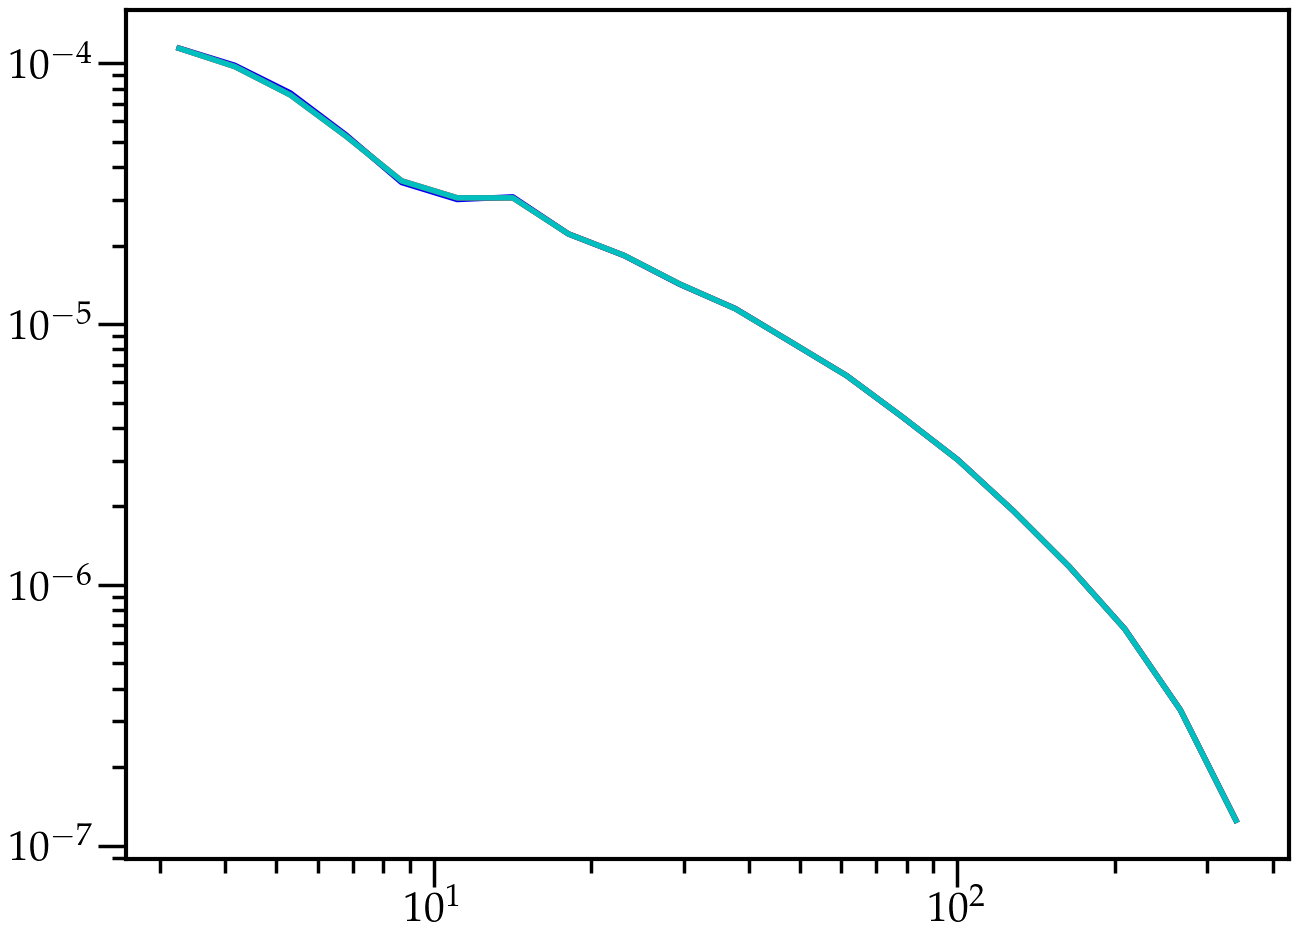

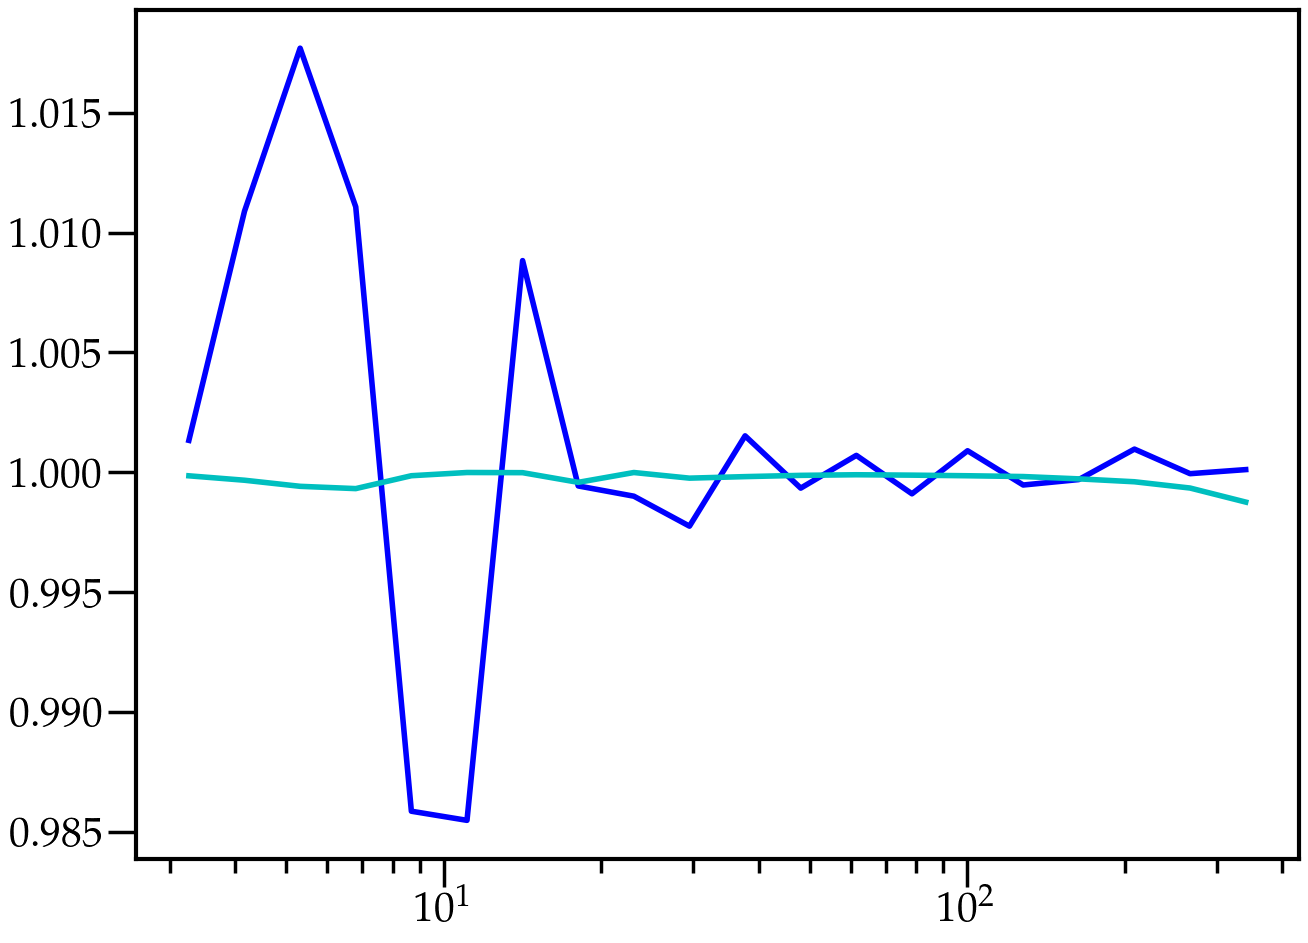

In [95]:
corr=corr_ll
plot(thb/d2r,xi0p_win['xi'][corr],'b')
plot(thb/d2r,xi0p_win_approx['xi'][corr],'r')
plot(thb/d2r,xi0p['xi'][corr],'c')
loglog()
show()
plot(thb/d2r,xi0p_win['xi'][corr]/xi0p_win_approx['xi'][corr],'b')
plot(thb/d2r,xi0p['xi'][corr]/xi0p_win_approx['xi'][corr],'c')
xscale('log')

(10, 400)

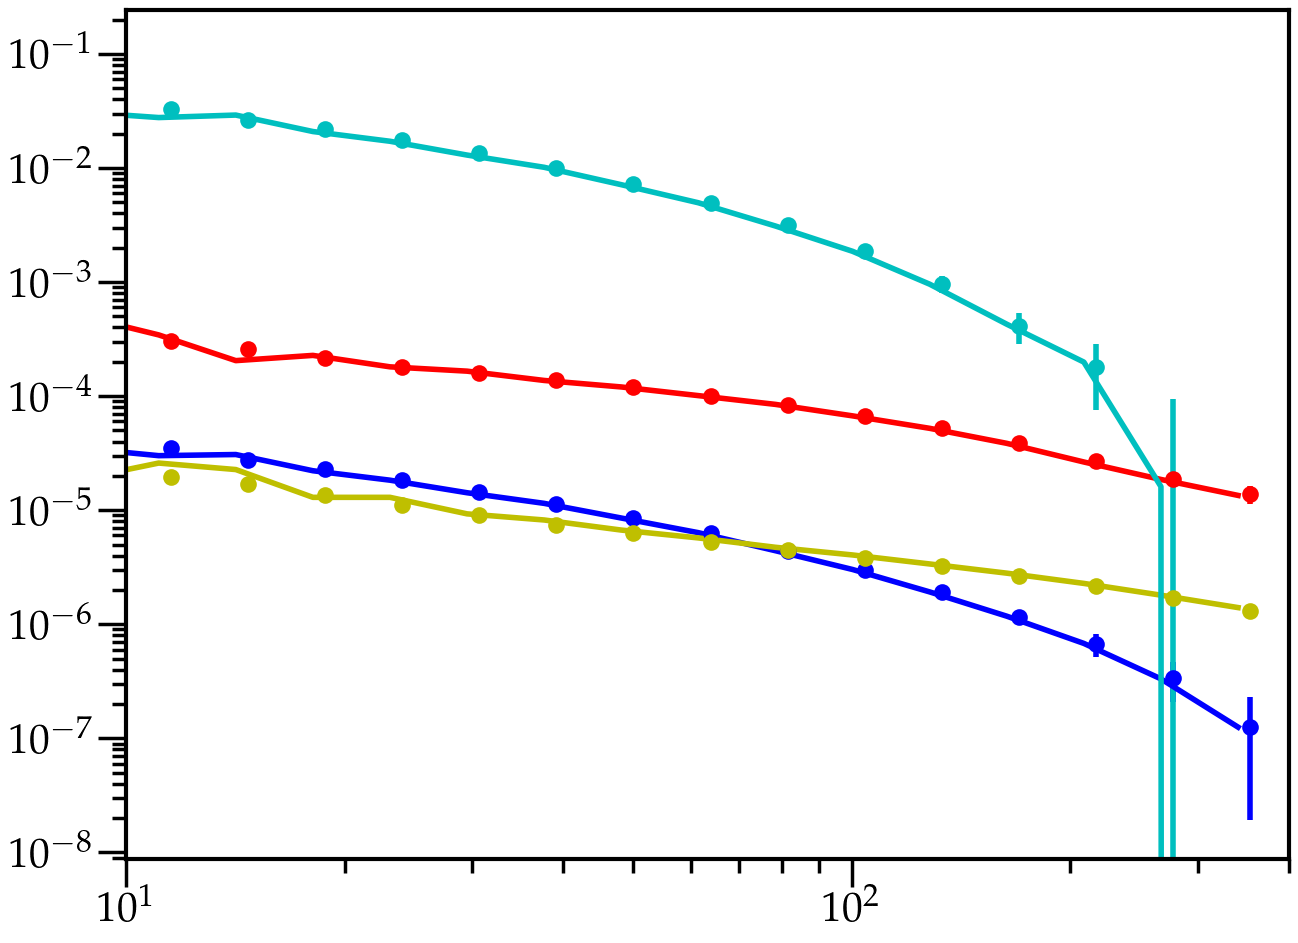

In [96]:
errorbar(xi_sim['th'],xi_sim['m'][:20],xi_sim['std'][:20],fmt='bo')
plot(thb/d2r,xi0p_win['xi'][corr_ll],'b')
errorbar(xi_sim['th'],xi_sim['m'][20:40],xi_sim['std'][20:40],fmt='yo')
plot(thb/d2r,xi0m_win['xi'][corr_ll],'y')
errorbar(xi_sim['th'],xi_sim['m'][40:60],xi_sim['std'][40:60],fmt='ro')
plot(thb/d2r,xi0p_win['xi'][corr_ggl],'r')
errorbar(xi_sim['th'],xi_sim['m'][60:80],xi_sim['std'][60:80],fmt='co')
plot(thb/d2r,xi0p_win['xi'][corr_gg],c='c')
loglog()
xlim(10,400)

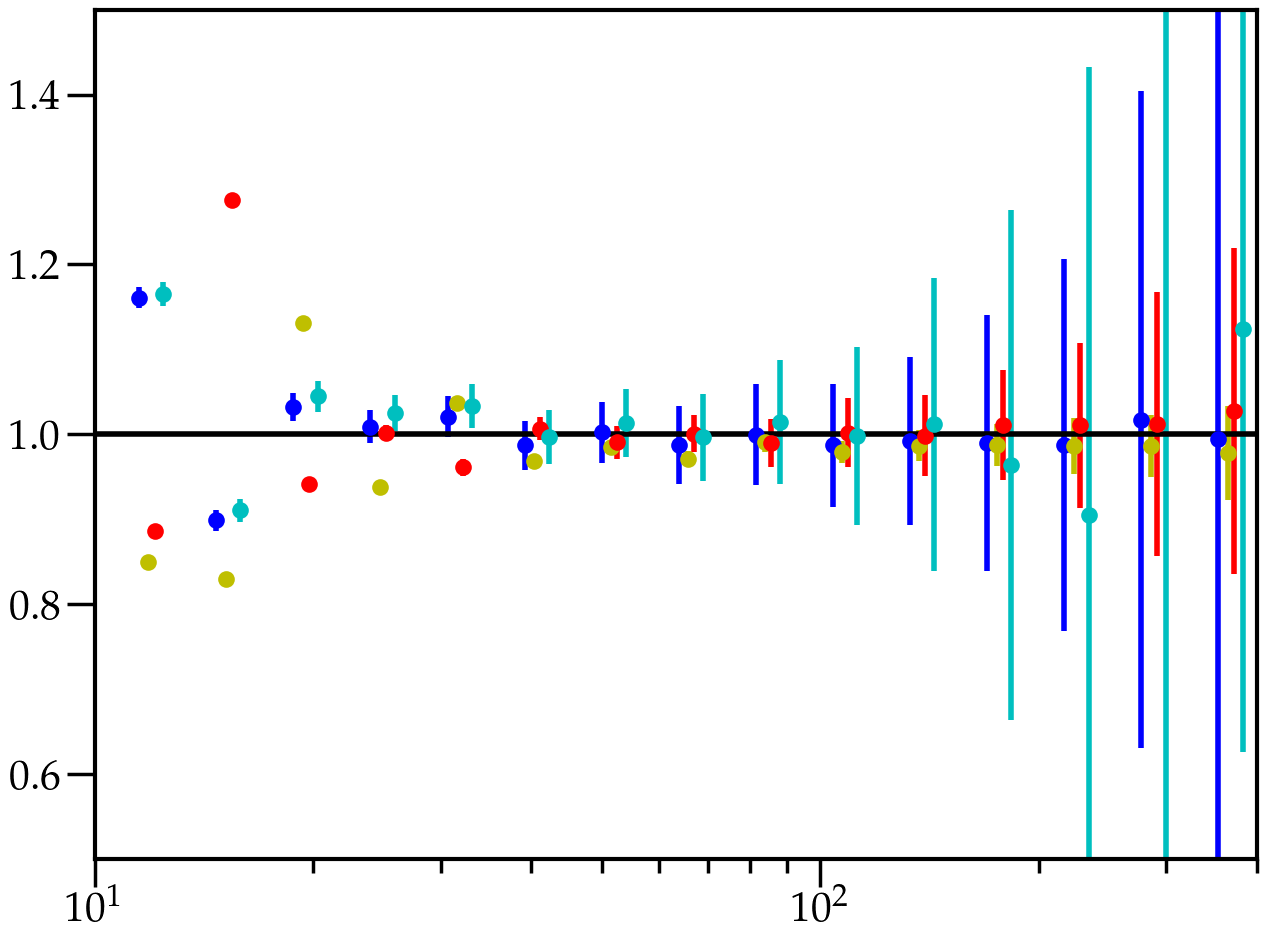

In [97]:
errorbar(xi_sim['th'],xi_sim['m'][:20]/xi0p['xi'][corr_ll],xi_sim['std'][:20]/xi0p['xi'][corr_ll],fmt='bo')
errorbar(xi_sim['th']*1.03,xi_sim['m'][20:40]/xi0m['xi'][corr_ll],xi_sim['std'][20:40]/xi0m['xi'][corr_ll],fmt='yo')
errorbar(xi_sim['th']*1.05,xi_sim['m'][40:60]/xi0p['xi'][corr_ggl],xi_sim['std'][40:60]/xi0p['xi'][corr_ggl],fmt='ro')

errorbar(xi_sim['th']*1.08,xi_sim['m'][60:80]/xi0p['xi'][corr_gg],xi_sim['std'][60:80]/xi0p['xi'][corr_gg],fmt='co')

xscale('log')
xlim(10,400)
ylim(0.5,1.5)
hlines(1,10,400)

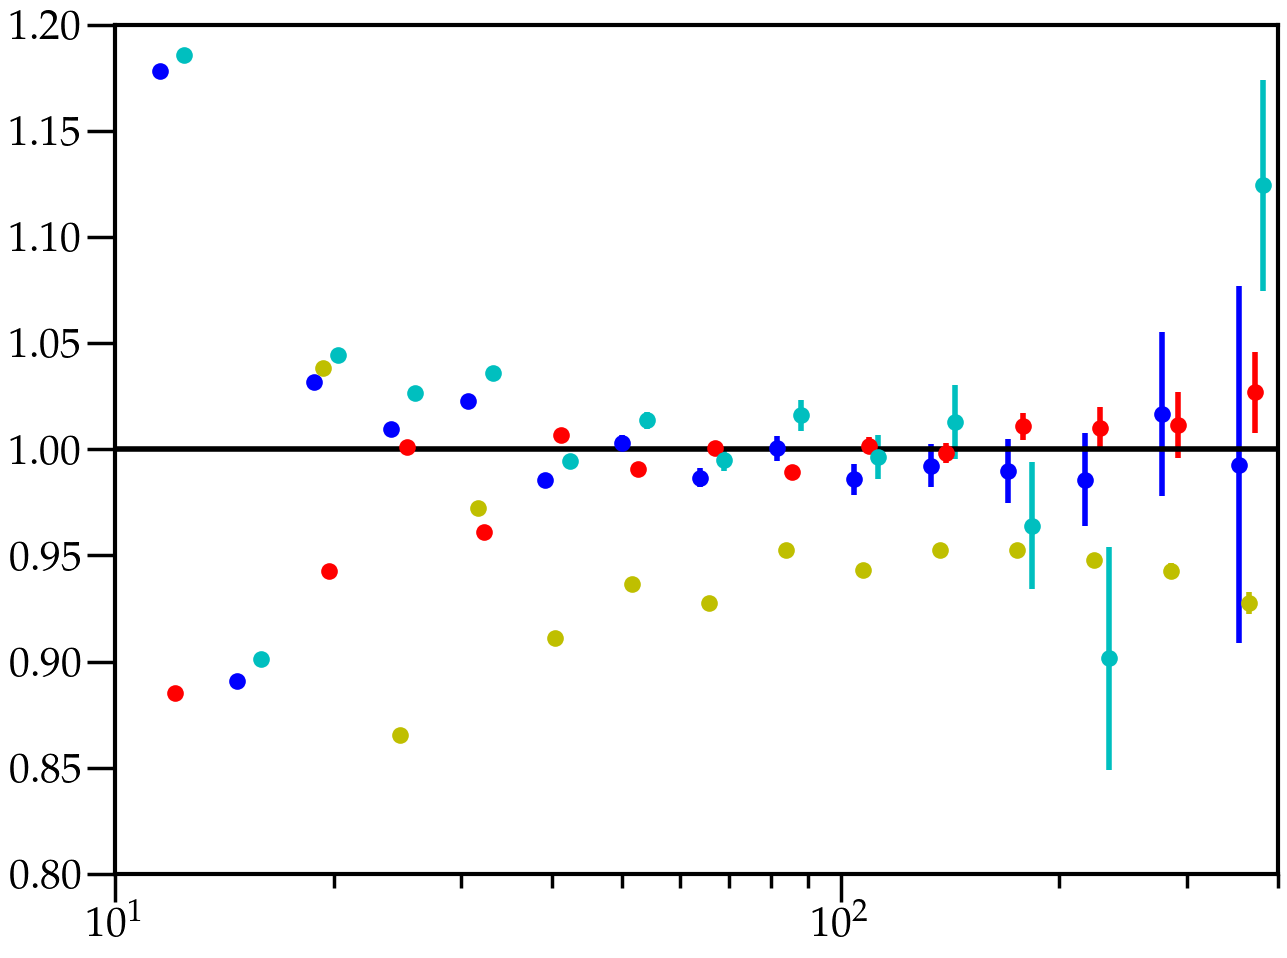

In [163]:
errorbar(xi_sim['th'],xi_sim['m'][:20]/xi0p_win['xi'][corr_ll],xi_sim['std'][:20]/xi0p_win['xi'][corr_ll]/10,fmt='bo')
errorbar(xi_sim['th']*1.03,xi_sim['m'][20:40]/xi0m_win['xi'][corr_ll],xi_sim['std'][20:40]/xi0m_win['xi'][corr_ll]/10,fmt='yo')
errorbar(xi_sim['th']*1.05,xi_sim['m'][40:60]/xi0p_win['xi'][corr_ggl],xi_sim['std'][40:60]/xi0p_win['xi'][corr_ggl]/10,fmt='ro')

errorbar(xi_sim['th']*1.08,xi_sim['m'][60:80]/xi0p_win['xi'][corr_gg],xi_sim['std'][60:80]/xi0p_win['xi'][corr_gg]/10,fmt='co')

xscale('log')
xlim(10,400)
ylim(0.8,1.2)
hlines(1,10,400)

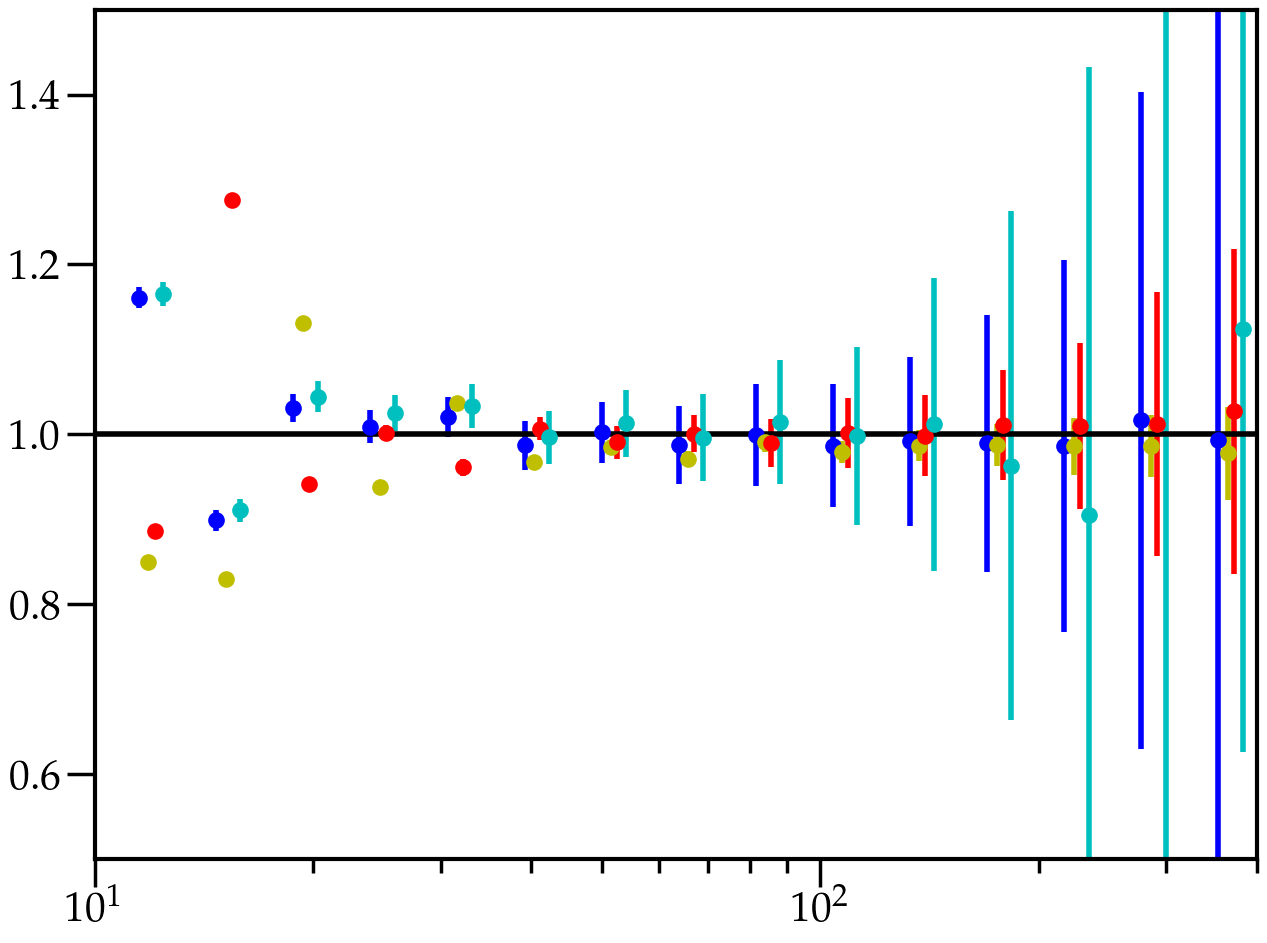

In [99]:
errorbar(xi_sim['th'],xi_sim['m'][:20]/xi0p_win_approx['xi'][corr_ll],xi_sim['std'][:20]/xi0p_win_approx['xi'][corr_ll],fmt='bo')
errorbar(xi_sim['th']*1.03,xi_sim['m'][20:40]/xi0m_win_approx['xi'][corr_ll],xi_sim['std'][20:40]/xi0m_win_approx['xi'][corr_ll],fmt='yo')
errorbar(xi_sim['th']*1.05,xi_sim['m'][40:60]/xi0p_win_approx['xi'][corr_ggl],xi_sim['std'][40:60]/xi0p_win_approx['xi'][corr_ggl],fmt='ro')

errorbar(xi_sim['th']*1.08,xi_sim['m'][60:80]/xi0p_win_approx['xi'][corr_gg],xi_sim['std'][60:80]/xi0p_win_approx['xi'][corr_gg],fmt='co')

xscale('log')
xlim(10,400)
ylim(0.5,1.5)
hlines(1,10,400)

In [100]:
kappa_win.Win.Win['cov'][corr_gg+corr_gg][bi+bi]['M'][1324].keys()

dict_keys(['clcl', 'Ncl', 'clN', 'NN'])

In [117]:
dict_load['data_vectors'].shape

(100, 100)

<ErrorbarContainer object of 3 artists>

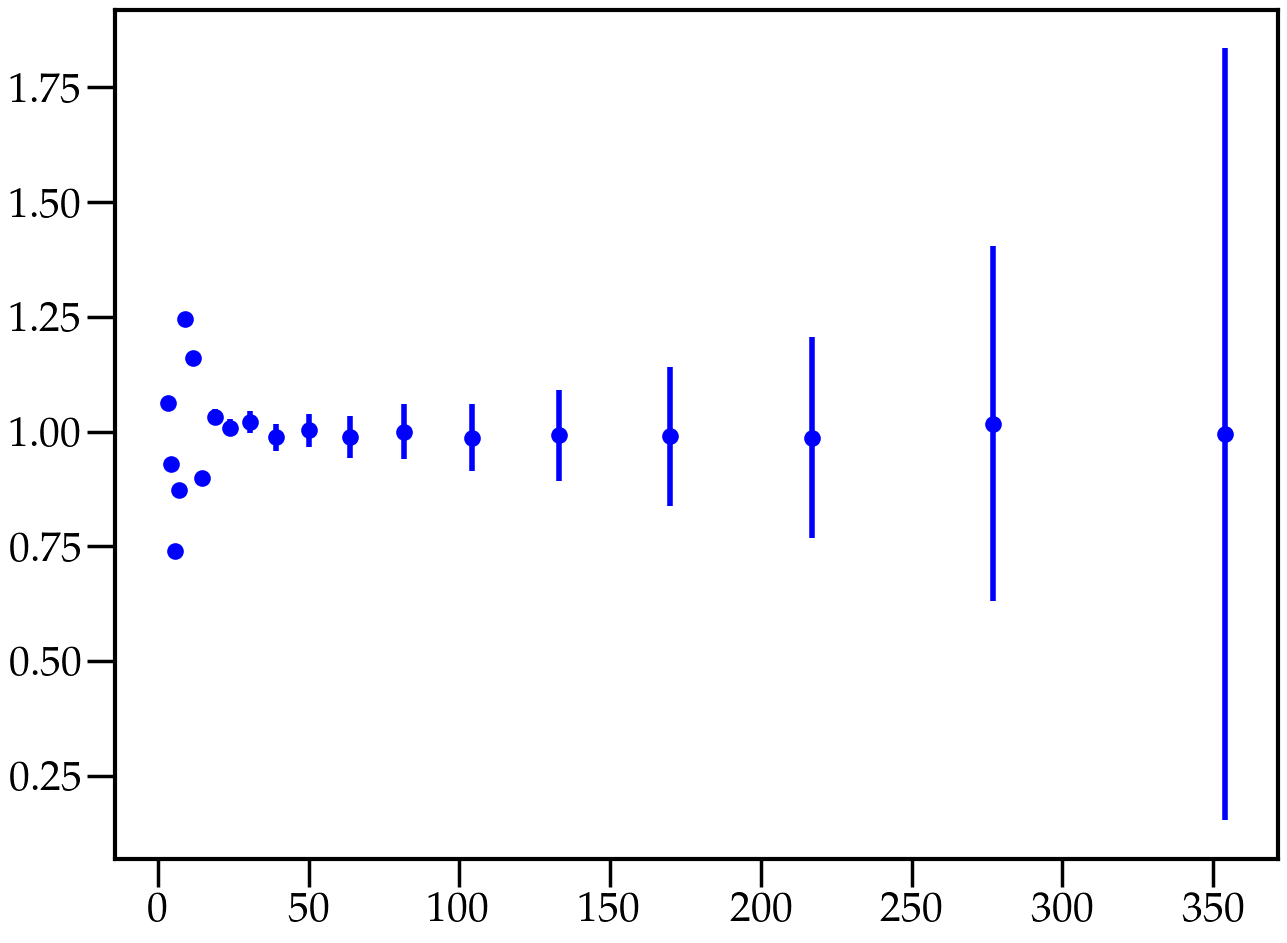

In [125]:
errorbar(xi_sim['th'],np.mean(dict_load['data_vectors'][:,0:20],axis=0)/xi0p['xi'][corr_ll],xi_sim['std'][:20]/xi0p['xi'][corr_ll],fmt='bo')


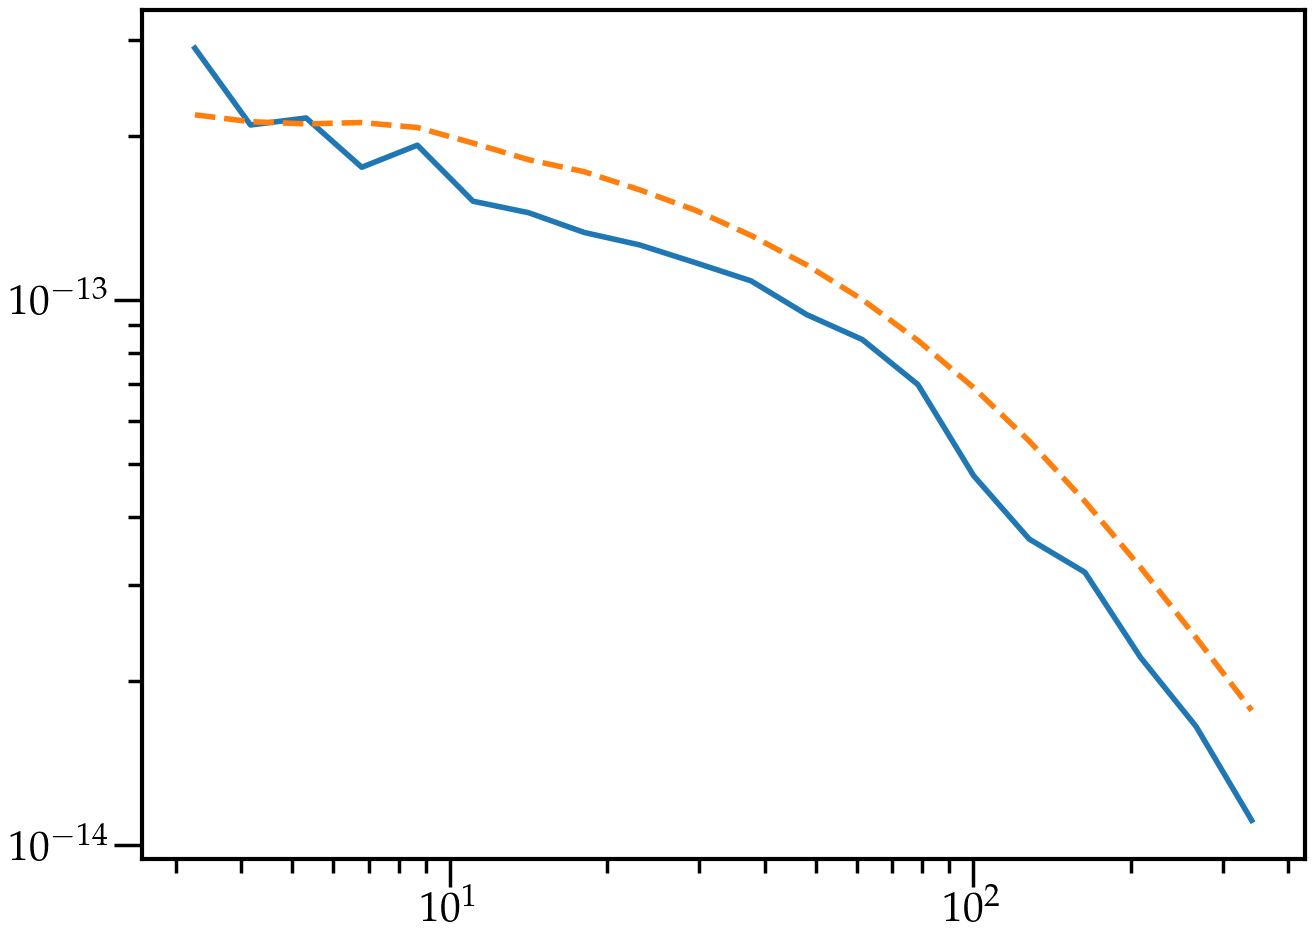

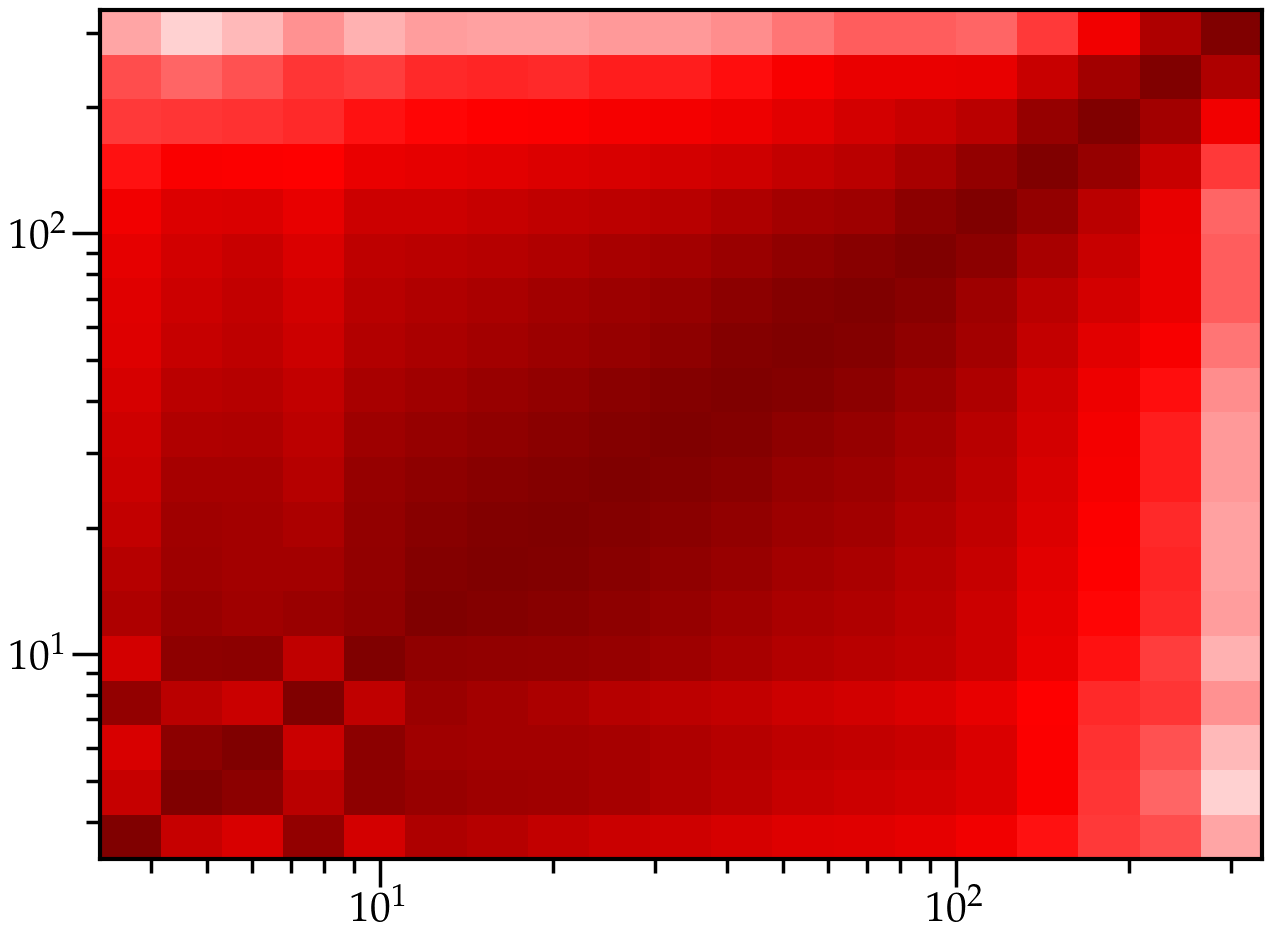

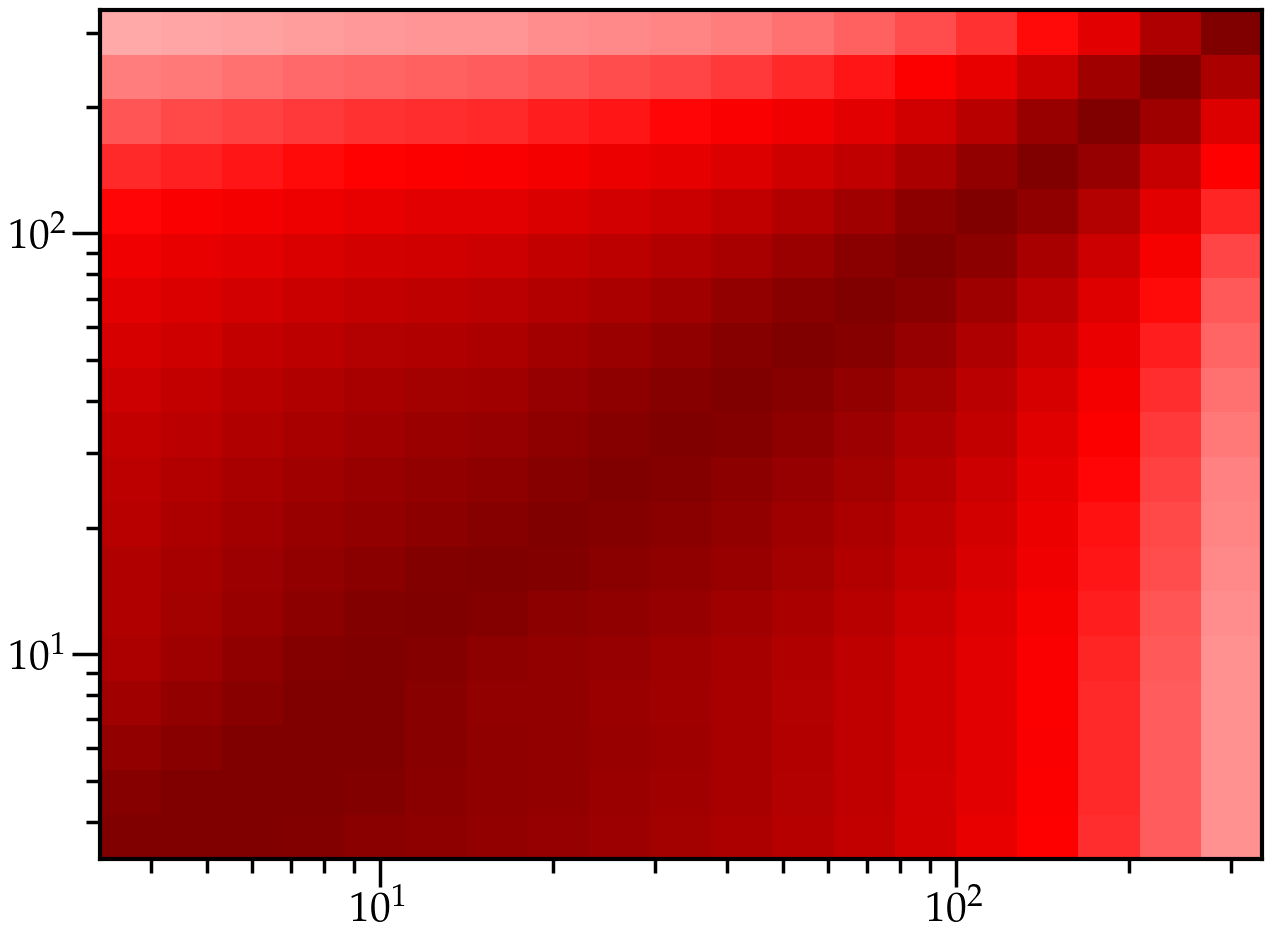

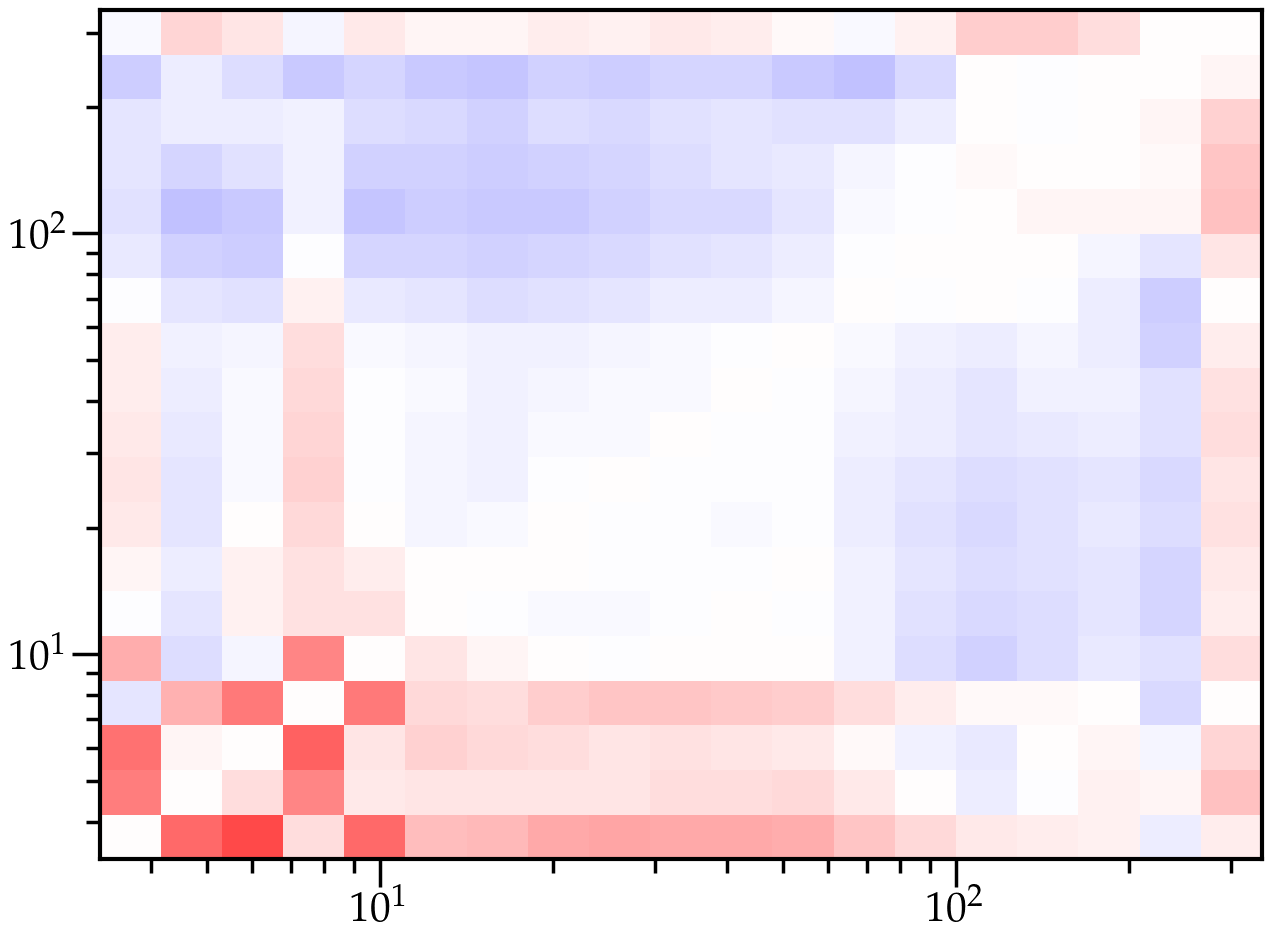

In [162]:
cov_sim=np.cov(dict_load['data_vectors'][:,0:20],rowvar=0)
cov_th=xi0p_win_approx['cov'][corr_ll]#['final']
corr_sim=corr_matrix(cov_sim)
corr_th=corr_matrix(cov_th)
err_sim=xi_sim['std'][:20]**2 #np.diag(cov_sim)
err_th=np.diag(cov_th)

plot(thb/d2r,err_sim)
plot(thb/d2r,err_th,'--')
loglog()
show()

pcolor(thb/d2r,thb/d2r,corr_sim,vmin=-1,vmax=1,cmap='seismic')
loglog()
show()
pcolor(thb/d2r,thb/d2r,corr_th,vmin=-1,vmax=1,cmap='seismic')
loglog()
show()
pcolor(thb/d2r,thb/d2r,corr_th-corr_sim,vmin=-1,vmax=1,cmap='seismic')
loglog()
show()

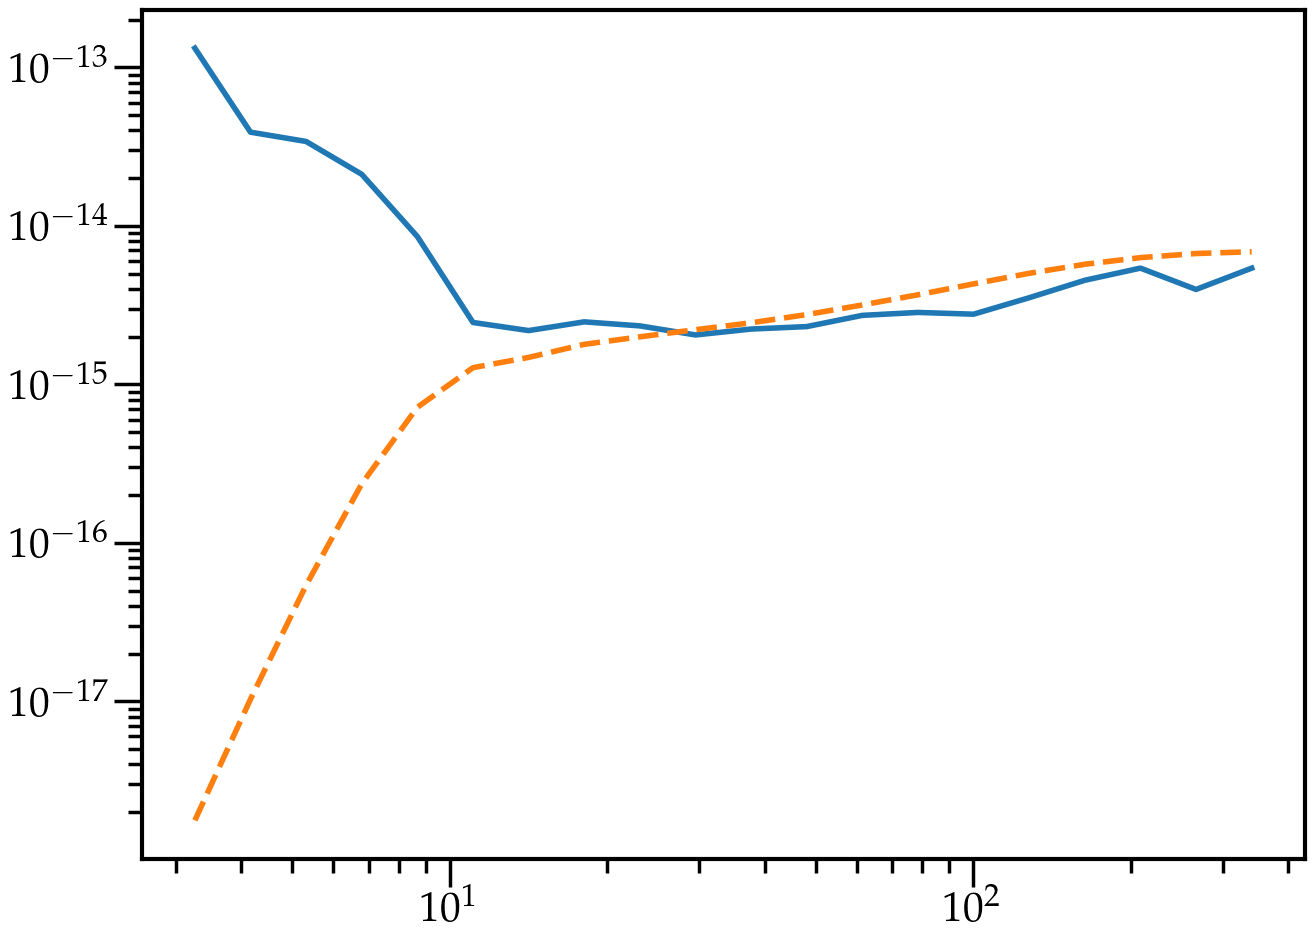

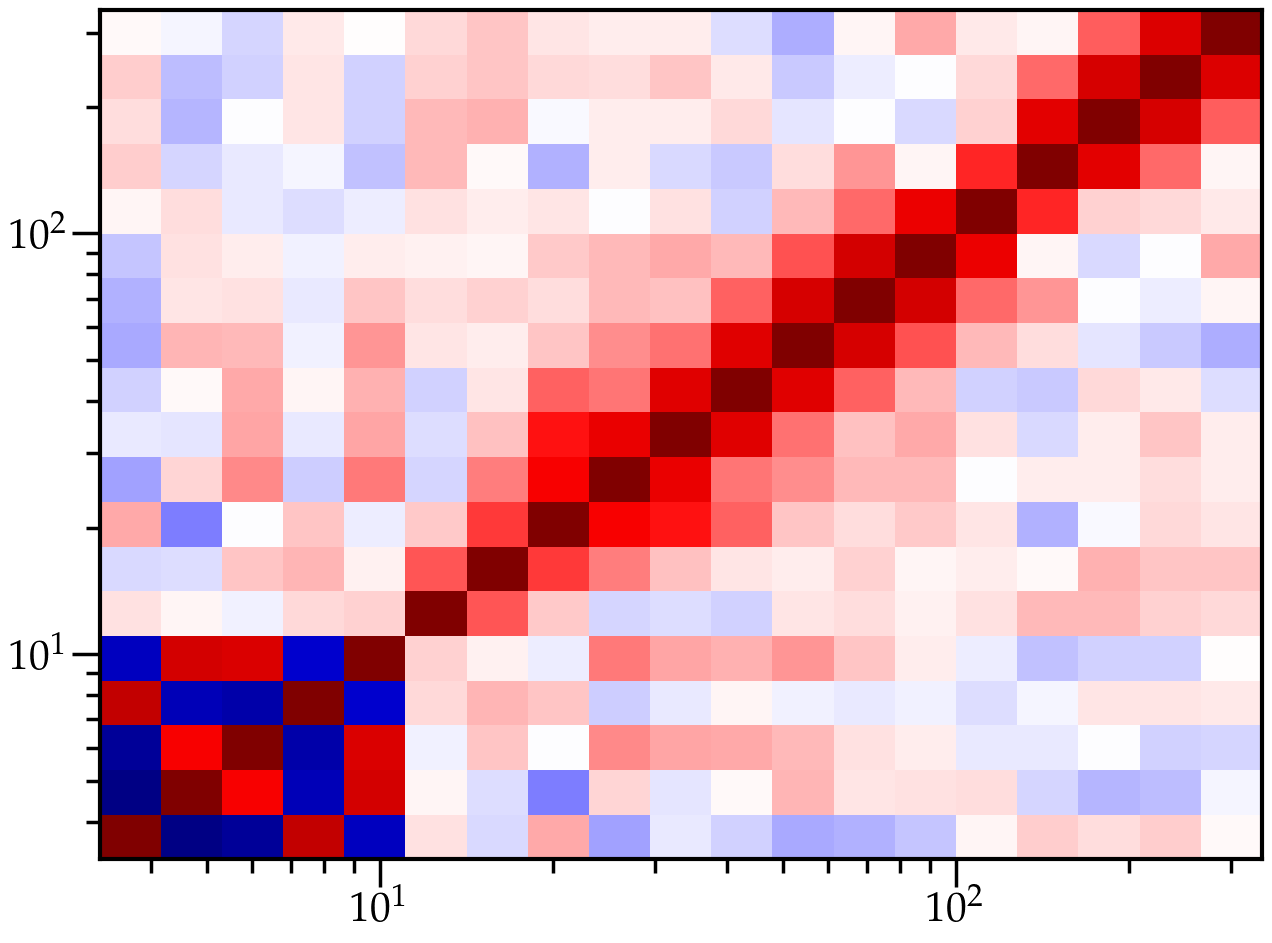

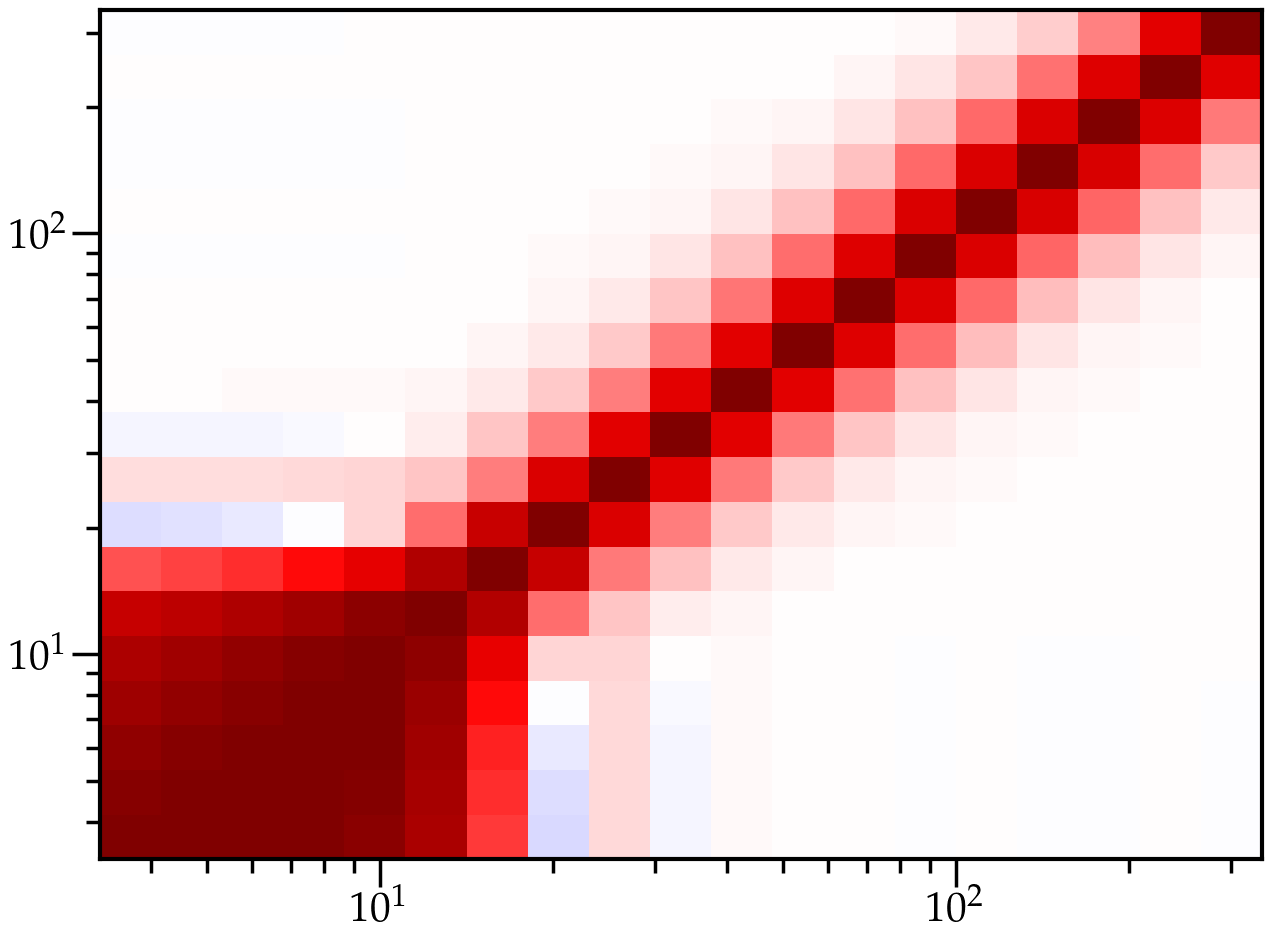

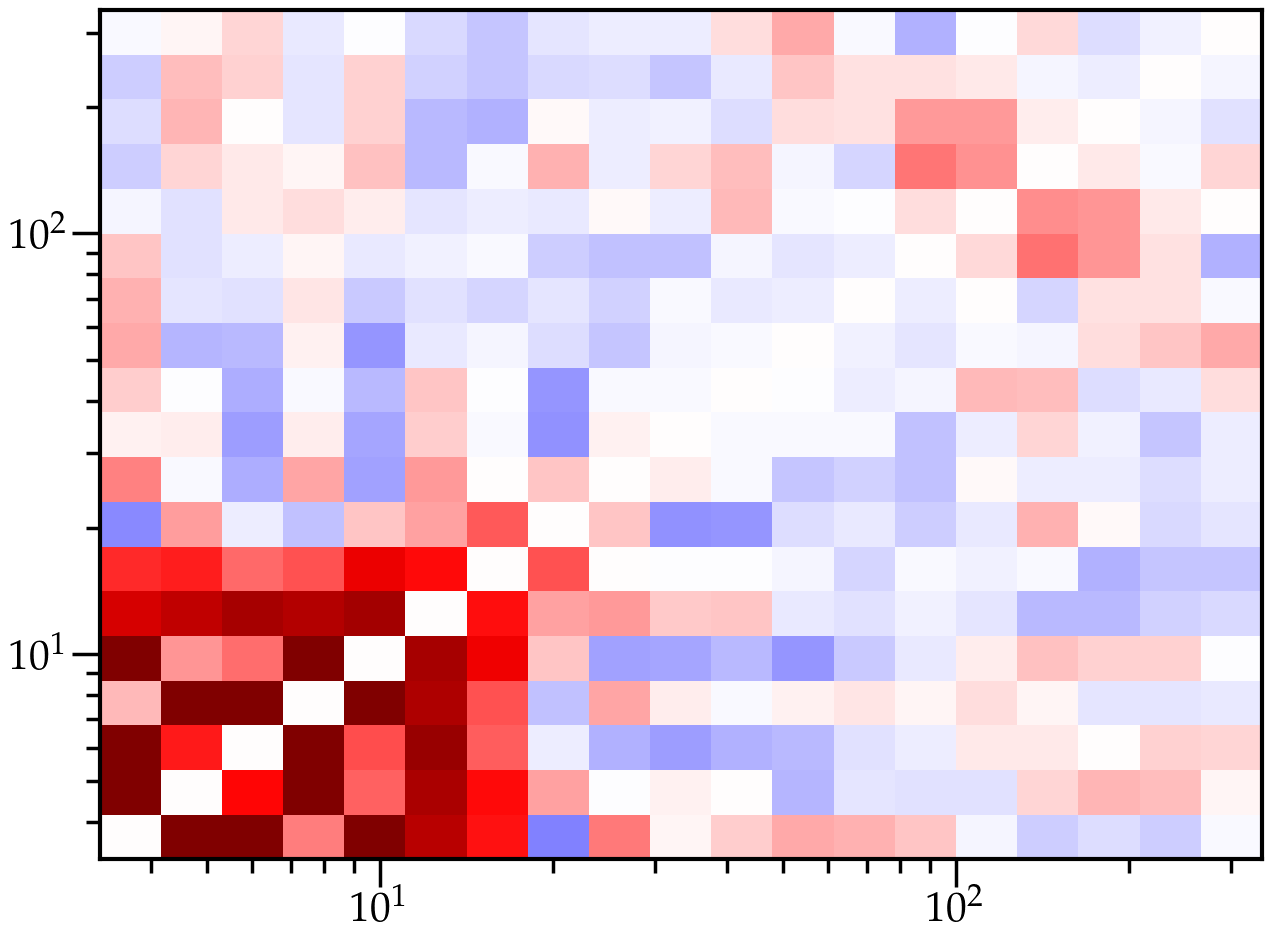

In [160]:
cov_sim=np.cov(dict_load['data_vectors'][:,20:40],rowvar=0)
cov_th=xi0m_win_approx['cov'][corr_ll]
corr_sim=corr_matrix(cov_sim)
corr_th=corr_matrix(cov_th)
err_sim=np.diag(cov_sim)
err_th=np.diag(cov_th)

plot(thb/d2r,err_sim)
plot(thb/d2r,err_th/1.4,'--')
loglog()
show()

pcolor(thb/d2r,thb/d2r,corr_sim,vmin=-1,vmax=1,cmap='seismic')
loglog()
show()
pcolor(thb/d2r,thb/d2r,corr_th,vmin=-1,vmax=1,cmap='seismic')
loglog()
show()
pcolor(thb/d2r,thb/d2r,corr_th-corr_sim,vmin=-1,vmax=1,cmap='seismic')
loglog()
show()

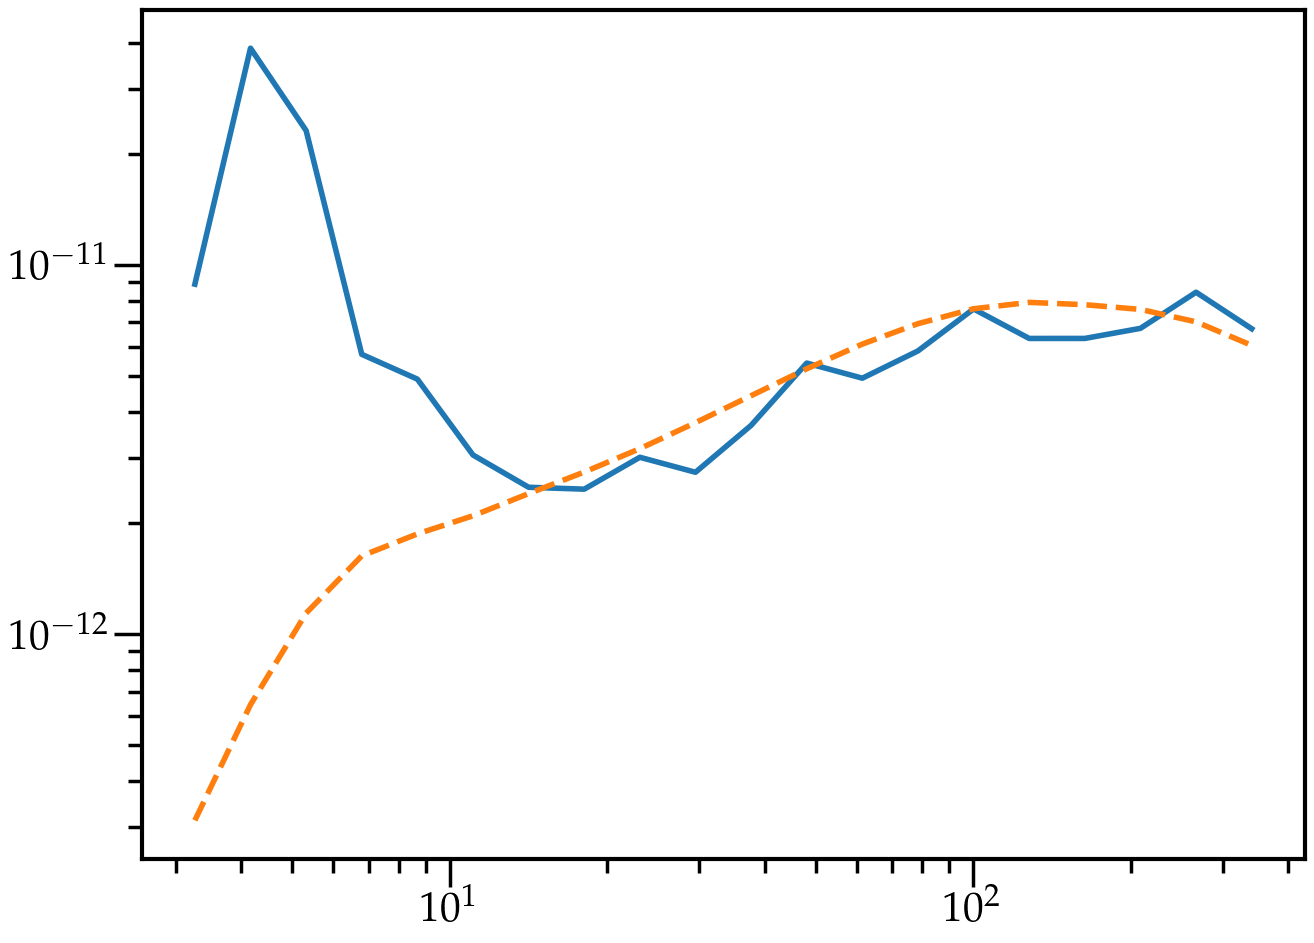

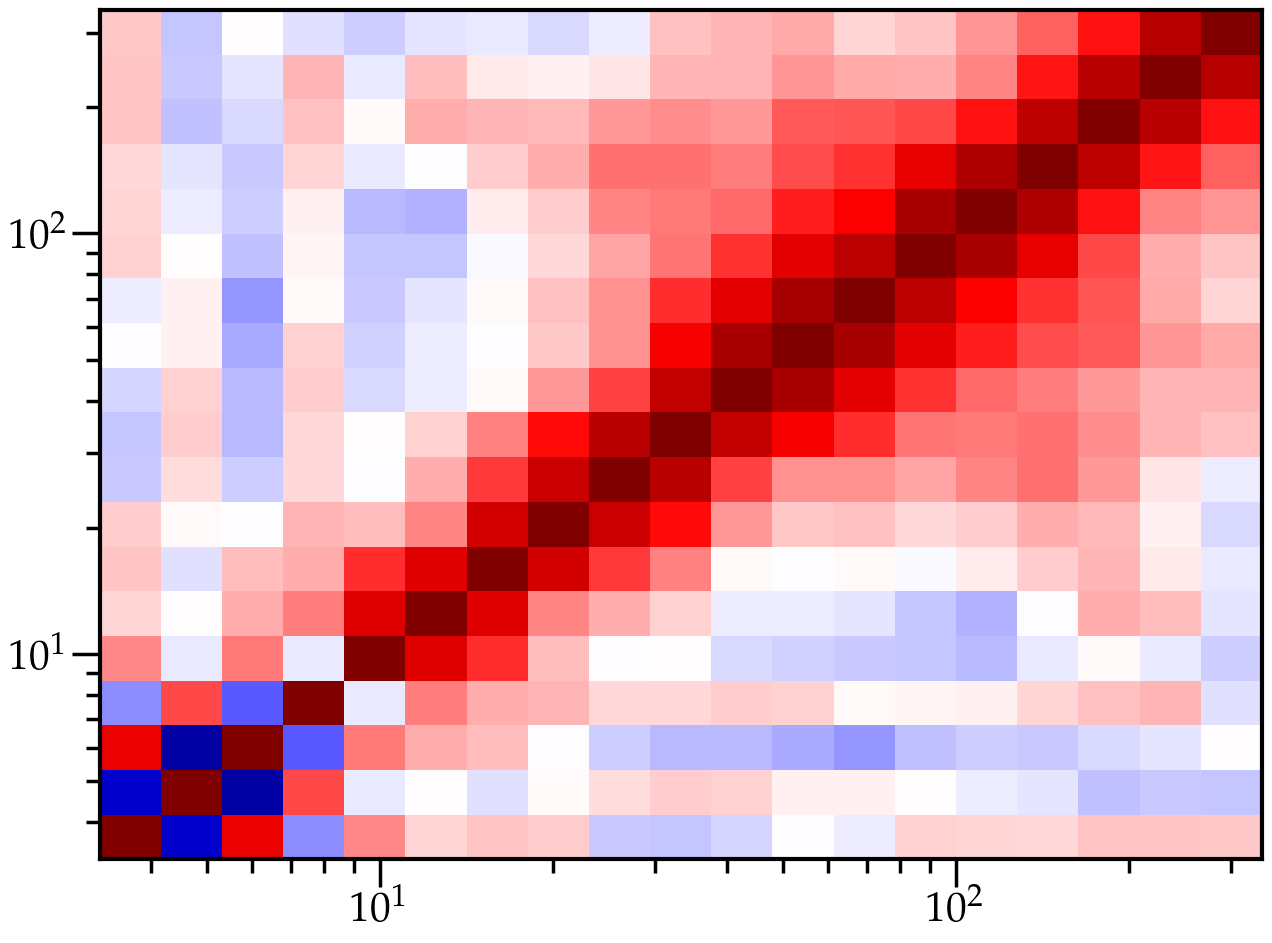

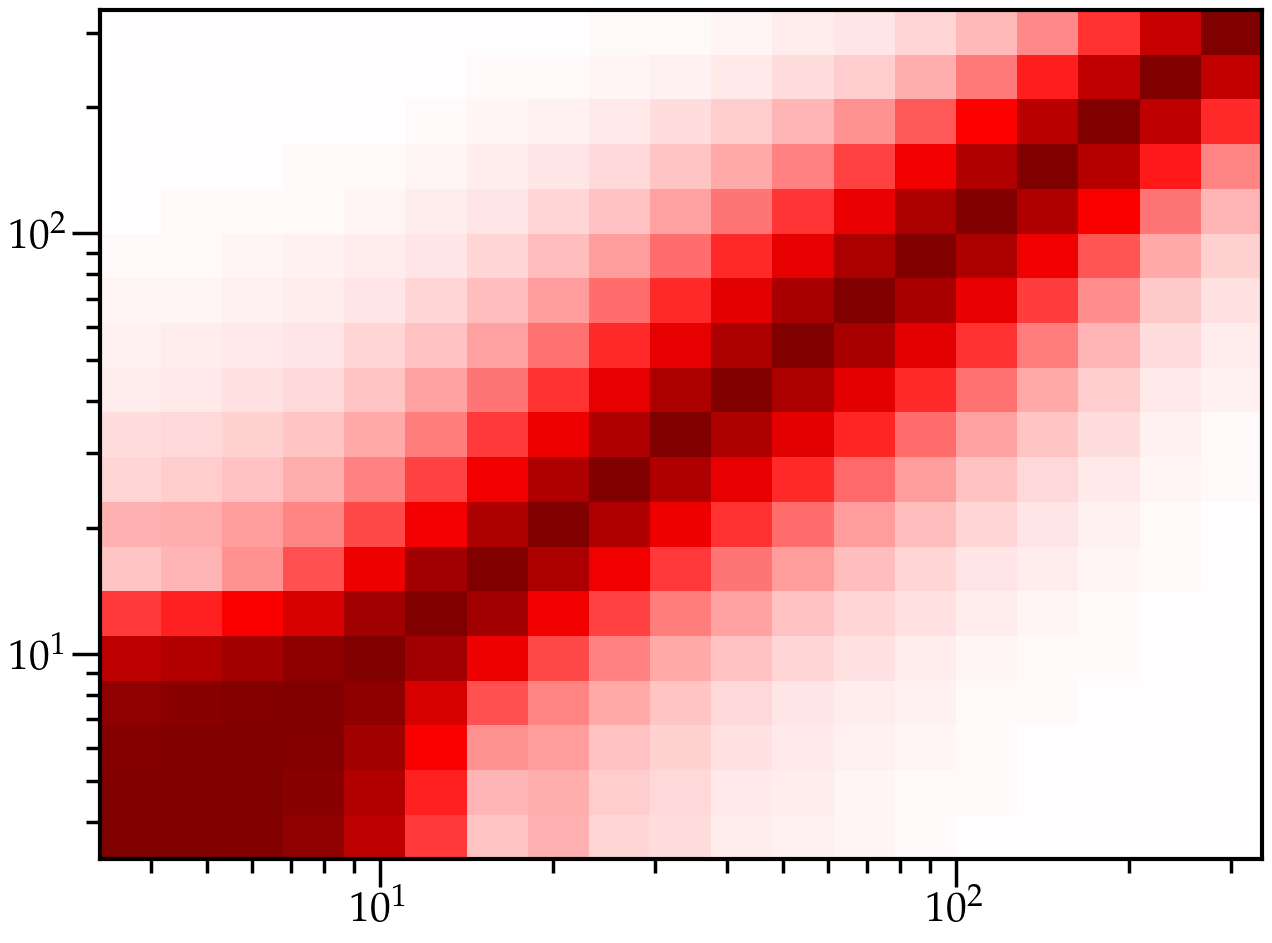

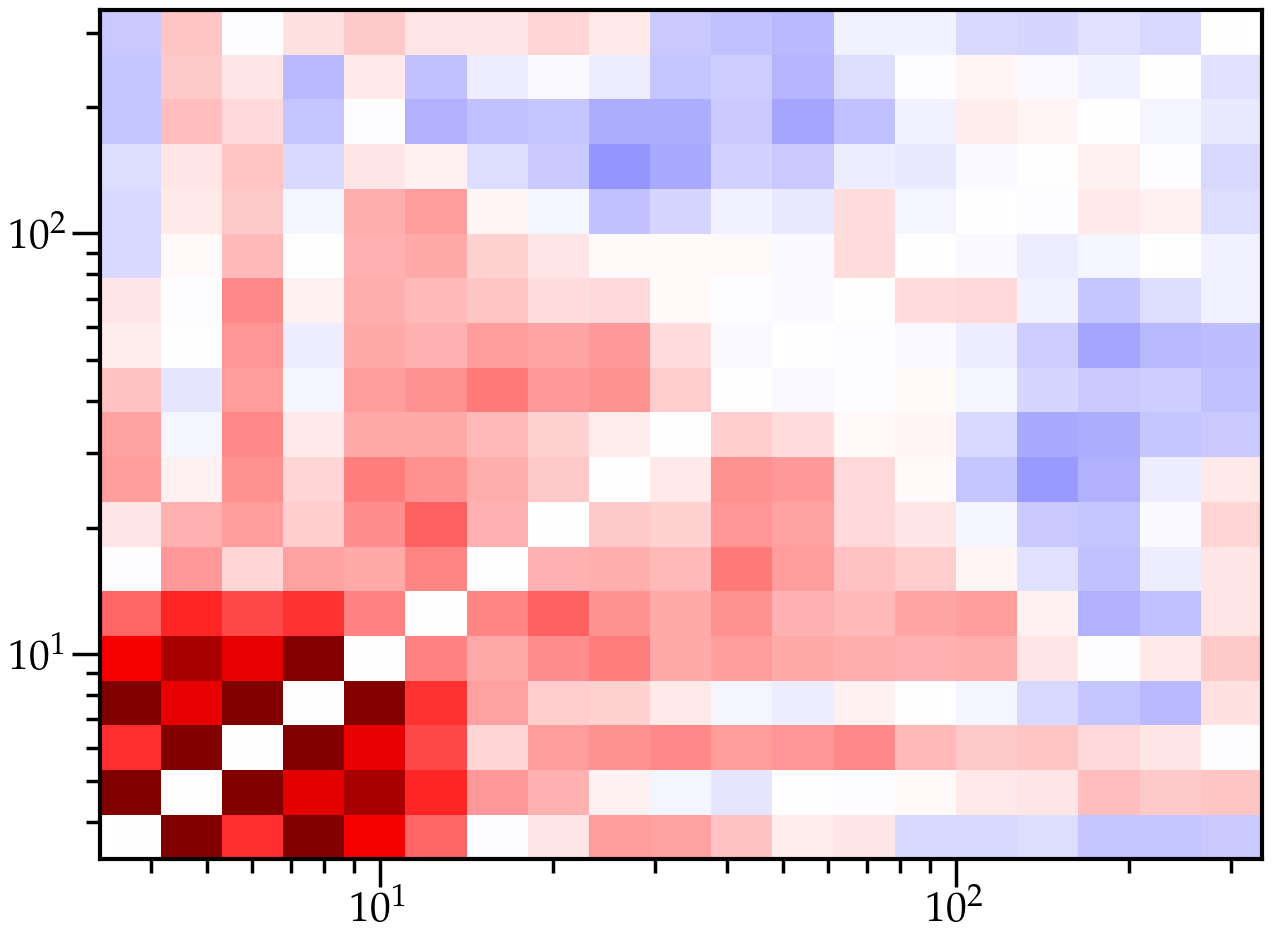

In [159]:
cov_sim=np.cov(dict_load['data_vectors'][:,40:60],rowvar=0)
cov_th=xi0p_win_approx['cov'][corr_ggl]#['final']
corr_sim=corr_matrix(cov_sim)
corr_th=corr_matrix(cov_th)
err_sim=np.diag(cov_sim)
err_th=np.diag(cov_th)

plot(thb/d2r,err_sim)
plot(thb/d2r,err_th/1.4,'--')
loglog()
show()

pcolor(thb/d2r,thb/d2r,corr_sim,vmin=-1,vmax=1,cmap='seismic')
loglog()
show()
pcolor(thb/d2r,thb/d2r,corr_th,vmin=-1,vmax=1,cmap='seismic')
loglog()
show()
pcolor(thb/d2r,thb/d2r,corr_th-corr_sim,vmin=-1,vmax=1,cmap='seismic')
loglog()
show()

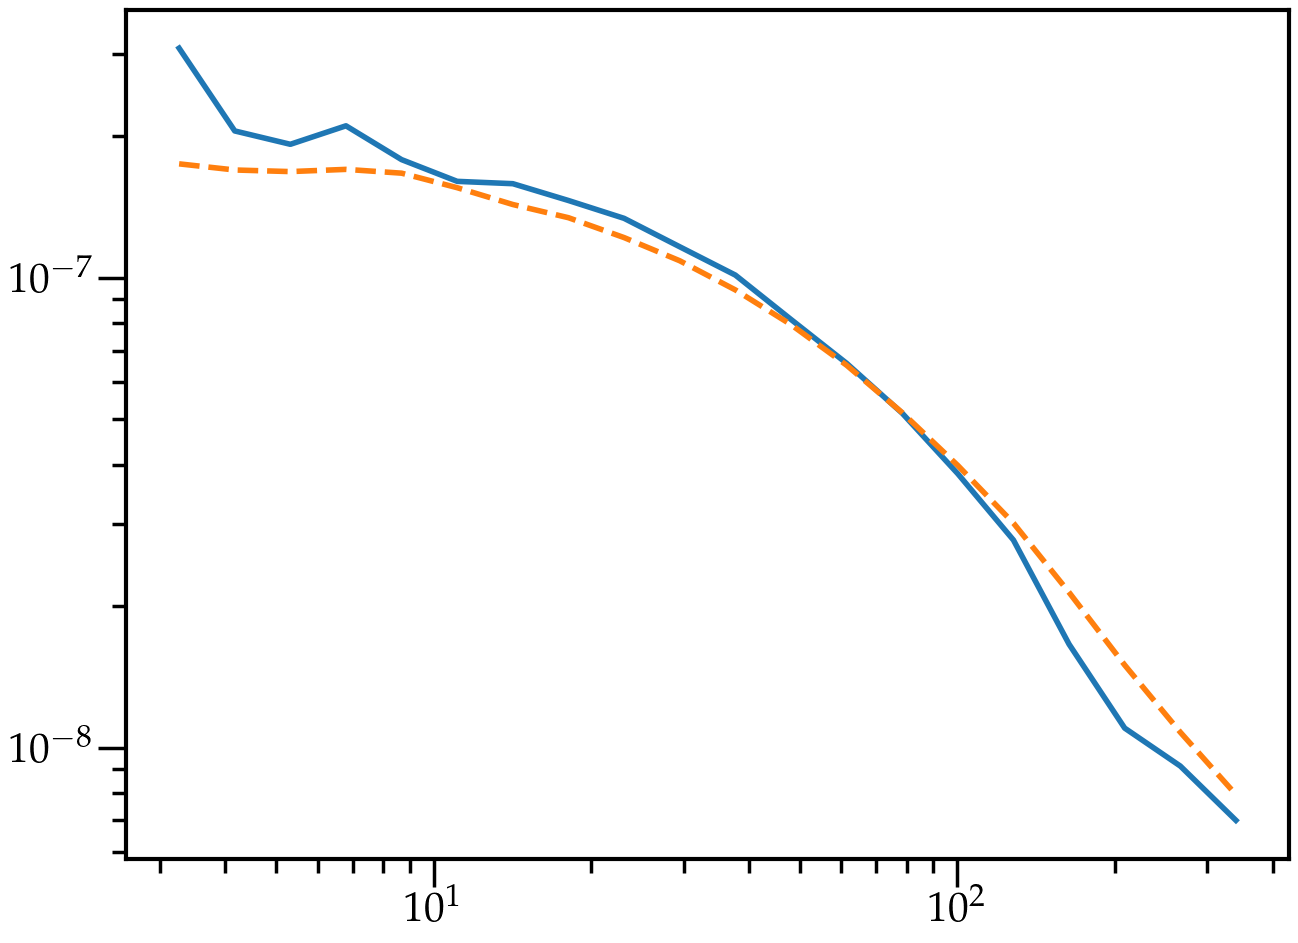

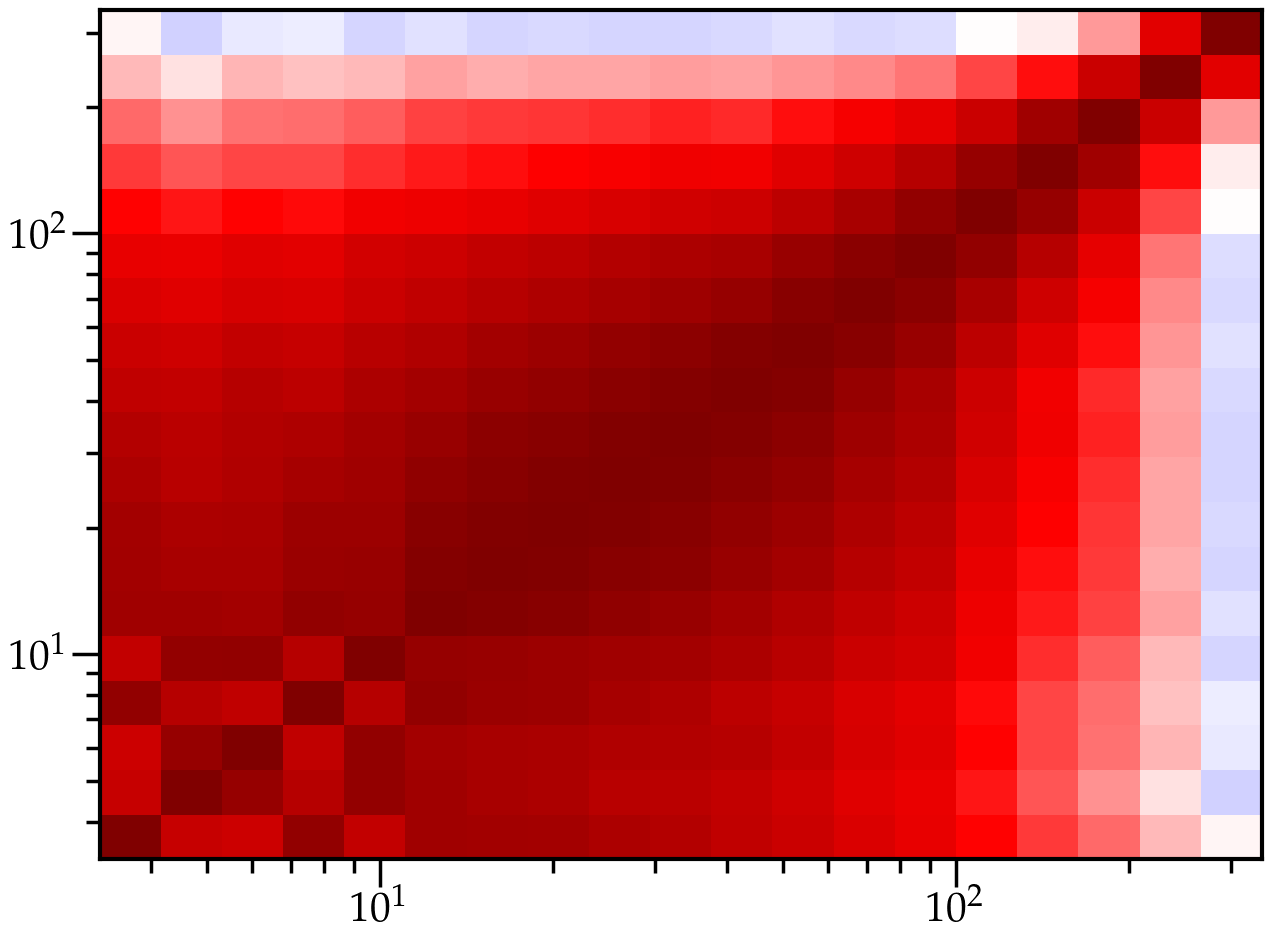

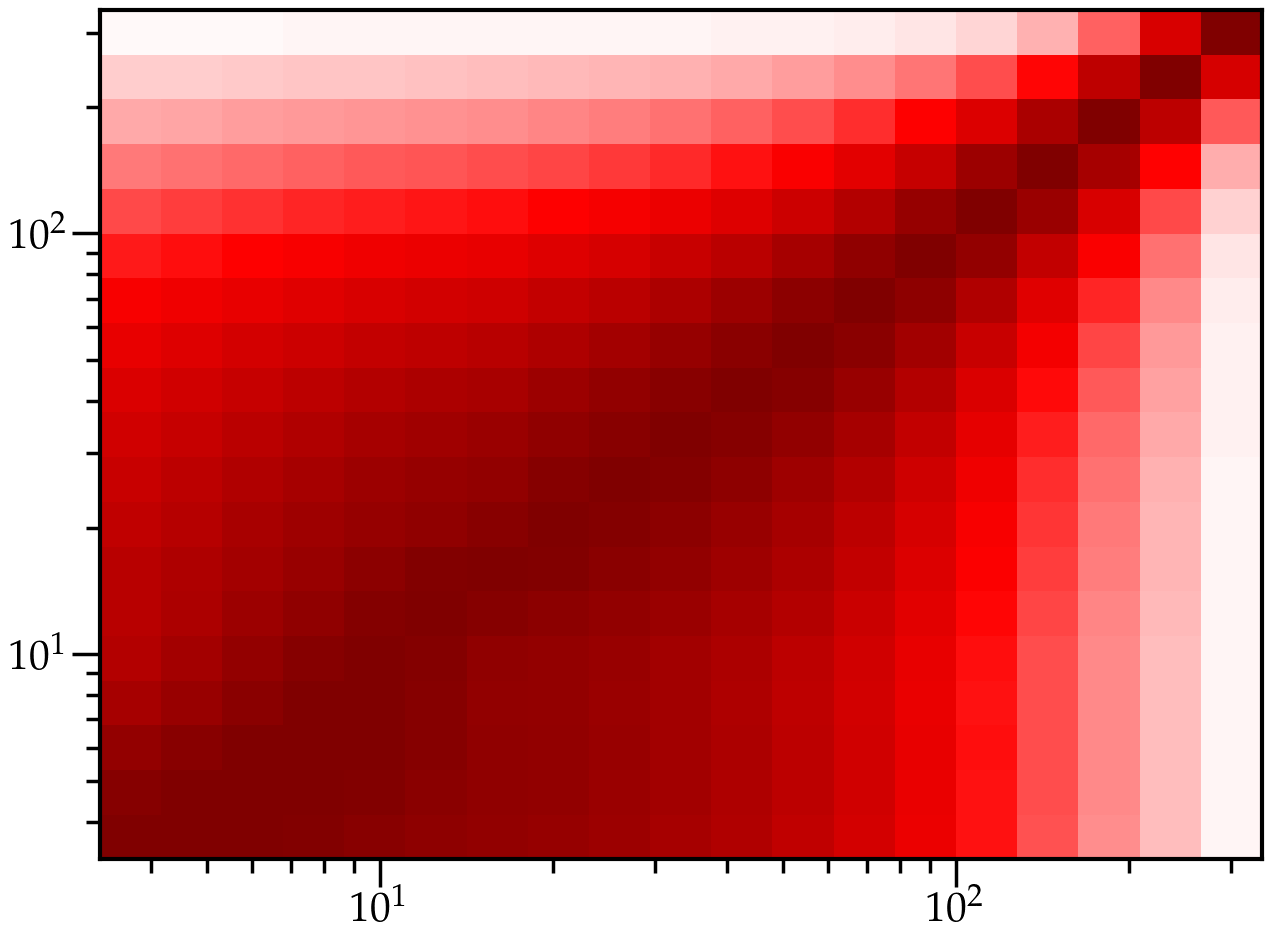

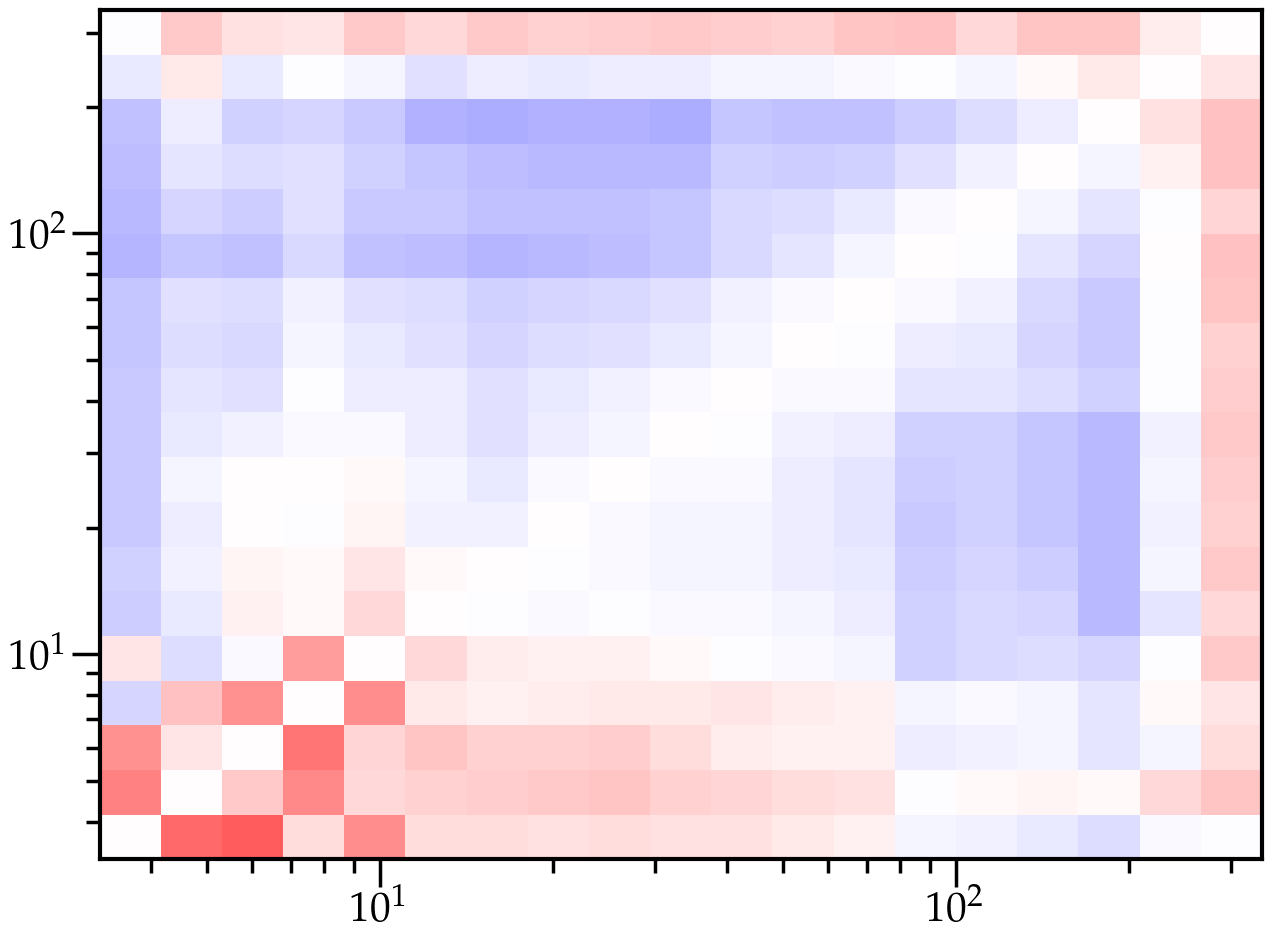

In [158]:
cov_sim=np.cov(dict_load['data_vectors'][:,60:80],rowvar=0)
cov_th=xi0p_win_approx['cov'][corr_gg]#['final']
corr_sim=corr_matrix(cov_sim)
corr_th=corr_matrix(cov_th)
err_sim=np.diag(cov_sim)
err_th=np.diag(cov_th)

plot(thb/d2r,err_sim)
plot(thb/d2r,err_th/1.4,'--')
loglog()
show()

pcolor(thb/d2r,thb/d2r,corr_sim,vmin=-1,vmax=1,cmap='seismic')
loglog()
show()
pcolor(thb/d2r,thb/d2r,corr_th,vmin=-1,vmax=1,cmap='seismic')
loglog()
show()
pcolor(thb/d2r,thb/d2r,corr_th-corr_sim,vmin=-1,vmax=1,cmap='seismic')
loglog()
show()

In [105]:
def wigner_d(m1,m2,theta,l,l_use_bessel=1.e4):
    l0=np.copy(l)
    if l_use_bessel is not None:
    #FIXME: This is not great. Due to a issues with the scipy hypergeometric function,
    #jacobi can output nan for large ell, l>1.e4
    # As a temporary fix, for ell>1.e4, we are replacing the wigner function with the
    # bessel function. Fingers and toes crossed!!!
    # mpmath is slower and also has convergence issues at large ell.
    #https://github.com/scipy/scipy/issues/4446
    
    #FIX: Can use recursion reltion from Kilbinger+ 2017
        l=np.atleast_1d(l)
        x=l<l_use_bessel
        l=np.atleast_1d(l[x])
    k=np.amin([l-m1,l-m2,l+m1,l+m2],axis=0)
    a=np.absolute(m1-m2)
    lamb=0 #lambda
    if m2>m1:
        lamb=m2-m1
    b=2*l-2*k-a
    d_mat=(-1)**lamb
    d_mat*=np.sqrt(binom(2*l-k,k+a)) #this gives array of shape l with elements choose(2l[i]-k[i], k[i]+a)
    d_mat/=np.sqrt(binom(k+b,b))
    d_mat=np.atleast_1d(d_mat)
    x=k<0
    d_mat[x]=0

    d_mat=d_mat.reshape(1,len(d_mat))
    theta=theta.reshape(len(theta),1)
    d_mat=d_mat*((np.sin(theta/2.0)**a)*(np.cos(theta/2.0)**b))
    d_mat*=jacobi(l,a,b,np.cos(theta))

    if l_use_bessel is not None:
        l=np.atleast_1d(l0)
        x=l>=l_use_bessel
        l=np.atleast_1d(l[x])
#         d_mat[:,x]=jn(m1-m2,l[x]*theta)
        d_mat=np.append(d_mat,jn(m1-m2,l*theta),axis=1)
    return d_mat

In [106]:
def wigner_d_recur(m1,m2,theta,l,l_use_bessel=1.e4):
    dmat=np.zeros((len(theta),len(l)))
    theta=theta.reshape(len(theta),1)
    l=l.reshape(1,len(l))
    d100=np.cos(theta)
    
    A0=l*(2.*l-1.)
    A0/=np.sqrt((l**2-m1**2)*(l**2-m2**2))
    
    A1=d100-m1*m2*1.0/l/(l-1.)
    
    A2=np.sqrt(((l-1)**2-m1**2)*((l-1)**2-m2**2))
    A2/=(l-1)*(2*l-1)
    il=0
    for i in np.arange(len(l[0,:])):
        if l[0,i]<np.absolute(m1) or l[0,i]<np.absolute(m2):
            continue
        if il<=2:
            dmat[:,i]=wigner_d(m1,m2,theta,np.atleast_1d(l[0,i]),l_use_bessel=l_use_bessel)[:,0]
            il+=1
        else:
            dmat[:,i]=A1[:,i]*dmat[:,i-1]-A2[0,i]*dmat[:,i-2]
            dmat[:,i]*=A0[0,i]
    return dmat

In [107]:
from scipy.special import lpmv
def wigner_d_recur_legendre(m1,m2,theta,l,l_use_bessel=1.e4):
    if m1!=0 and m2!=0:
        return 0
    dmat=np.zeros((len(theta),len(l)))
    theta=theta.reshape(len(theta),1)
    

    m=max(np.absolute(m1),np.absolute(m2))
    logA=log_factorial(l-m)-log_factorial(l+m)
    A=np.exp(.5*logA)
    print(l,m,A)
    x=l<m
    A[x]=0
    
    l=l.reshape(1,len(l))
    
    A0=l-m*1.0
    A1=(2.*l-1.)*np.cos(theta)
    A2=l-1.+m
    il=0
    for i in np.arange(len(l[0,:])):
        if l[0,i]<m:
            continue
        if il<=200:
            dmat[:,i]=lpmv(m,l[0,i],np.cos(theta[:,0]))
            print(m,l[0,i],dmat[:,i])
#             dmat[:,i]=lpmv(l[0,i],m,np.cos(theta[:,0]))
            il+=1

        else:
            dmat[:,i]=A1[:,i]*dmat[:,i-1]-A2[0,i]*dmat[:,i-2]
            dmat[:,i]/=A0[0,i]
    dmat*=A
    return dmat

In [108]:
m1m2=(2,0)
%time wigd=wigner_d_parallel(m1m2[0],m1m2[1],WT_L.theta[m1m2][:20],l0)

./wigner_functions.py:39: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))


CPU times: user 121 ms, sys: 824 ms, total: 944 ms
Wall time: 920 ms


In [ ]:
%time wigdr=wigner_d_recur_legendre(m1m2[0],m1m2[1],WT_L.theta[m1m2][:20],l0)

In [ ]:
wigner_d_recur_legendre(m1m2[0],m1m2[1],np.atleast_1d(WT_L.theta[m1m2][0]),l0[2:3])

In [ ]:
wigner_d_parallel(m1m2[0],m1m2[1],np.atleast_1d(WT_L.theta[m1m2][0]),l0[2:3])

In [ ]:
lpmv(2,3,np.cos(WT_L.theta[m1m2][:20]))

In [ ]:
np.all(np.isclose(wigdr,wigd,rtol=1.e-4,atol=0))

In [ ]:
thi=0

In [ ]:
wigd[thi,:],wigdr[thi,:]

In [ ]:
lpmv(2,3,.1)

In [ ]:
wigdr[thi,:][:10]

In [ ]:
plot(l0,wigd[thi,:])
plot(l0,wigdr[thi,:],'--')
xscale('log')
loglog()

In [ ]:
thi=11
plot(l0,wigd[thi,:]/wigdr[thi,:])
# plot(l0,)
xscale('log')

In [ ]:
thi=11
plot(l0,wigd[thi,:]-wigdr[thi,:])
# plot(l0,wigdr[thi,:],'--')
# loglog()
xscale('log')